In [1]:
#Run in conda env created with open2c_env.yml
#This is an example script of analysis and plotting of results for Hi-C datasets. 
#It is run from within the 'scripts' subdirectory, using following directory structure:
#Analysis_Dir
#├── data
#├── figures
#├── scripts
#├── lsf_jobs


In [2]:
#Very useful examples of cooltools analysis and docs: https://cooltools.readthedocs.io/en/latest/notebooks/viz.html

#Import the packages we will use
#Utilities
import os
import re
import itertools
from itertools import combinations
import glob
import pickle
import argparse

#Data Management
import numpy as np
from numpy import diff
import pandas as pd
import h5py
import scipy
from scipy.stats import linregress
from scipy import ndimage
from functools import partial
from scipy.linalg import toeplitz

#Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import seaborn as sns
import upsetplot
from upsetplot import UpSet

#Genomics
import pairtools
import cooler
import cooltools
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
import bioframe
from bioframe import overlap
import bbi
from cooltools import insulation

In [3]:
#Using previously processed mapq30 filtered and sampled to the same read-depth within each experiment cooler files

In [4]:
cooltools.__version__

'0.5.1'

In [5]:
bioframe.__version__

'0.3.3'

In [6]:
cooler.__version__

'0.8.11'

In [7]:
#Set up the sample names/files/directories needed
outDataDir = '..' #this is where the read normalized .mcool files are saved

conditions = [
    'AS_DMSO_R1',
    'AS_ICRF_R1',
    'MR_t4DMSO_R1',
    'MR_t4ICRF_R1',
    'MR_t8DMSO_R1',
    'MR_t8ICRF_R1',
    'AS_DMSO_R2',
    'AS_ICRF_R2',
    'MR_t4DMSO_R2',
    'MR_t4ICRF_R2',
    'MR_t8DMSO_R2',
    'MR_t8ICRF_R2',
    'AS_DMSO_R1R2',
    'AS_ICRF_R1R2',
    'MR_t4DMSO_R1R2',
    'MR_t4ICRF_R1R2',
    'MR_t8DMSO_R1R2',
    'MR_t8ICRF_R1R2',
]

long_names = {
    'AS_DMSO_R1' : 'TI-HiC-Dpn-HeLa-G1Sort-DMSO-2hr-4-29-R1-T1',
    'AS_ICRF_R1' : 'TI-HiC-Dpn-HeLa-G1Sort-ICRF-2hr-4-29-R1-T1',
    'MR_t4DMSO_R1' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t4hr-DMSO-2hr-G1Sort-4-44-R1-T1',
    'MR_t4ICRF_R1' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t4hr-ICRF-2hr-G1Sort-4-44-R1-T1',
    'MR_t8DMSO_R1' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t8hr-DMSO-6hr-G1Sort-4-44-R1-T1',
    'MR_t8ICRF_R1' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t8hr-ICRF-6hr-G1Sort-4-44-R1-T1',
    'AS_DMSO_R2' : 'TI-HiC-Dpn-HeLa-G1Sort-DMSO-2hr-4-48-R2-T1',
    'AS_ICRF_R2' : 'TI-HiC-Dpn-HeLa-G1Sort-ICRF-2hr-4-48-R2-T1',
    'MR_t4DMSO_R2' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t4hr-DMSO-2hr-G1Sort-4-49-R2-T1',
    'MR_t4ICRF_R2' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t4hr-ICRF-2hr-G1Sort-4-49-R2-T1',
    'MR_t8DMSO_R2' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t8hr-DMSO-6hr-G1Sort-4-49-R2-T1',
    'MR_t8ICRF_R2' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t8hr-ICRF-6hr-G1Sort-4-49-R2-T1',
    'AS_DMSO_R1R2' : 'TI-HiC-Dpn-HeLa-G1Sort-DMSO-2hr-R1R2',
    'AS_ICRF_R1R2' : 'TI-HiC-Dpn-HeLa-G1Sort-ICRF-2hr-R1R2',
    'MR_t4DMSO_R1R2': 'TI-HiC-Dpn-HeLa-MitoticRelease-t4hr-DMSO-2hr-G1Sort-R1R2',
    'MR_t4ICRF_R1R2' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t4hr-ICRF-2hr-G1Sort-R1R2',
    'MR_t8DMSO_R1R2' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t8hr-DMSO-6hr-G1Sort-R1R2',
    'MR_t8ICRF_R1R2' : 'TI-HiC-Dpn-HeLa-MitoticRelease-t8hr-ICRF-6hr-G1Sort-R1R2',
}

In [8]:
ComboConds = [
    'AS_DMSO_R1R2',
    'AS_ICRF_R1R2',
    'MR_t4DMSO_R1R2',
    'MR_t4ICRF_R1R2',
    'MR_t8DMSO_R1R2',
    'MR_t8ICRF_R1R2',
]

SepConds = [
    'AS_DMSO_R1',
    'AS_ICRF_R1',
    'MR_t4DMSO_R1',
    'MR_t4ICRF_R1',
    'MR_t8DMSO_R1',
    'MR_t8ICRF_R1',
    'AS_DMSO_R2',
    'AS_ICRF_R2',
    'MR_t4DMSO_R2',
    'MR_t4ICRF_R2',
    'MR_t8DMSO_R2',
    'MR_t8ICRF_R2'
]

ComboCtrlConds = [
    'AS_DMSO_R1R2',
    'MR_t4DMSO_R1R2',
    'MR_t4DMSO_R1R2',
    'MR_t8DMSO_R1R2'
]

ComboTreatConds = [
    'AS_ICRF_R1R2',
    'MR_t8DMSO_R1R2',
    'MR_t4ICRF_R1R2',
    'MR_t8ICRF_R1R2'
]

SepCtrlConds = [
    'AS_DMSO_R1',
    'MR_t4DMSO_R1',
    'MR_t4DMSO_R1',
    'MR_t8DMSO_R1',
    'AS_DMSO_R2',
    'MR_t4DMSO_R2',
    'MR_t4DMSO_R2',
    'MR_t8DMSO_R2'
]

SepTreatConds = [
    'AS_ICRF_R1',
    'MR_t8DMSO_R1',
    'MR_t4ICRF_R1',
    'MR_t8ICRF_R1',
    'AS_ICRF_R2',
    'MR_t8DMSO_R2',
    'MR_t4ICRF_R2',
    'MR_t8ICRF_R2'
]

In [9]:
#add colors for each sample

sampleColors = {
    'AS_DMSO_R1' : '#98DFEA',
    'AS_ICRF_R1' : '#E1B7A3',
    'MR_t4DMSO_R1' : '#17BECF',
    'MR_t4ICRF_R1' : '#D62728',    
    'MR_t8DMSO_R1' : '#0D6871',
    'MR_t8ICRF_R1' : '#751616',
    'AS_DMSO_R2' : '#98DFEA',
    'AS_ICRF_R2' : '#E1B7A3',
    'MR_t4DMSO_R2' : '#17BECF',
    'MR_t4ICRF_R2' : '#D62728',    
    'MR_t8DMSO_R2' : '#0D6871',
    'MR_t8ICRF_R2' : '#751616',
    'AS_DMSO_R1R2' : '#98DFEA',
    'AS_ICRF_R1R2' : '#E1B7A3',
    'MR_t4DMSO_R1R2' : '#17BECF',
    'MR_t4ICRF_R1R2' : '#D62728',    
    'MR_t8DMSO_R1R2' : '#0D6871',
    'MR_t8ICRF_R1R2' : '#751616',
}

sampleLineStyles = {
    'AS_DMSO_R1' : '-',
    'AS_ICRF_R1' : '-',
    'MR_t4DMSO_R1' : '-',
    'MR_t4ICRF_R1' : '-',  
    'MR_t8DMSO_R1' : '-',
    'MR_t8ICRF_R1' : '-',
    'AS_DMSO_R2' : ':',
    'AS_ICRF_R2' : ':',
    'MR_t4DMSO_R2' : ':',
    'MR_t4ICRF_R2' : ':',   
    'MR_t8DMSO_R2' : ':',
    'MR_t8ICRF_R2' : ':',
    'AS_DMSO_R1R2' : '-',
    'AS_ICRF_R1R2' : '-',
    'MR_t4DMSO_R1R2' : '-',
    'MR_t4ICRF_R1R2' : '-',   
    'MR_t8DMSO_R1R2' : '-',
    'MR_t8ICRF_R1R2' : '-',
}

samplePlotNames = {
    'AS_DMSO_R1' : 'AS DMSO, R1',
    'AS_ICRF_R1' : 'AS ICRF-193, R1',
    'MR_t4DMSO_R1' : 'MR t4 DMSO, R1',
    'MR_t4ICRF_R1' : 'MR t4 ICRF-193, R1', 
    'MR_t8DMSO_R1' : 'MR t8 DMSO, R1',
    'MR_t8ICRF_R1' : 'MR t8 ICRF-193, R1',
    'AS_DMSO_R2' : 'AS DMSO, R2',
    'AS_ICRF_R2' : 'AS ICRF-193, R2',
    'MR_t4DMSO_R2' : 'MR t4 DMSO, R2',
    'MR_t4ICRF_R2' : 'MR t4 ICRF-193, R2', 
    'MR_t8DMSO_R2' : 'MR t8 DMSO, R2',
    'MR_t8ICRF_R2' : 'MR t8 ICRF-193, R2',
    'AS_DMSO_R1R2' : 'AS DMSO',
    'AS_ICRF_R1R2' : 'AS ICRF-193',
    'MR_t4DMSO_R1R2' : 'MR t4 DMSO',
    'MR_t4ICRF_R1R2' : 'MR t4 ICRF-193',   
    'MR_t8DMSO_R1R2' : 'MR t8 DMSO',
    'MR_t8ICRF_R1R2' : 'MR t8 ICRF-193',
}

In [10]:
#Calculate eigenvectors (compartment calls) - 250kb bins

In [11]:
#coolers - 250kb bins
binsize = 250000

clr_paths_250kb = {}
for cond in conditions:
    clr_paths_250kb[cond] = f'{outDataDir}/data/{long_names[cond]}.sampled.hg38.mapq_30.1000.mcool::resolutions/{binsize}'
    
clrs250kb = {
    cond: cooler.Cooler(clr_paths_250kb[cond]) for cond in conditions
}

In [12]:
good_chroms = ['chr4', 'chr14', 'chr17', 'chr18', 'chr20', 'chr21'] #For HeLa S3 datasets, limited to only chromosomes
#with minimal translocations. All chromosomes were used for HCT116 datasets.

In [13]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
# create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)

In [14]:
# Select only chromosomes that are present in the good chromosomes
hg38_chromsizes = hg38_chromsizes.loc[good_chroms]
hg38_arms = hg38_arms[hg38_arms.chrom.isin(good_chroms)].reset_index(drop=True)
hg38_arms

chrom     start        end     name
0    chr4         0   50728006   chr4_p
1    chr4  50728006  190214555   chr4_q
2   chr14         0   17086761  chr14_p
3   chr14  17086761  107043718  chr14_q
4   chr17         0   24714921  chr17_p
5   chr17  24714921   83257441  chr17_q
6   chr18         0   18161052  chr18_p
7   chr18  18161052   80373285  chr18_q
8   chr20         0   28237290  chr20_p
9   chr20  28237290   64444167  chr20_q
10  chr21         0   11890184  chr21_p
11  chr21  11890184   46709983  chr21_q

In [15]:
bins = cooler.binnify(hg38_chromsizes, binsize)

In [16]:
from bioframe.io.resources import UCSCClient
mrna = UCSCClient('hg38').fetch_mrna()

In [18]:
genecov = bioframe.frac_gene_coverage(bins, mrna) 

In [19]:
genecov.head()

chrom    start      end  coverage  count
0  chr4        0   250000    152618    781
1  chr4   250000   500000    240641   1483
2  chr4   500000   750000    159353    934
3  chr4   750000  1000000    220790   1270
4  chr4  1000000  1250000    238261    783

In [21]:
#Get compartments, flip based on gene density, good chroms by arm only
#Not sorting by variance compared to gene density, instead by variance explained of data

lam = {}
eigs = {}

for cond in conditions:
    lam[cond], eigs[cond] = cooltools.eigs_cis(
        clrs250kb[cond], 
        genecov,
        n_eigs=3, 
        ignore_diags=2,
        view_df = hg38_arms
    )

/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


In [22]:
for cond in conditions:
    # Save text files
    lam[cond].to_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.lam.txt', sep='\t')


In [23]:
hg38_arms.head()

chrom     start        end     name
0   chr4         0   50728006   chr4_p
1   chr4  50728006  190214555   chr4_q
2  chr14         0   17086761  chr14_p
3  chr14  17086761  107043718  chr14_q
4  chr17         0   24714921  chr17_p

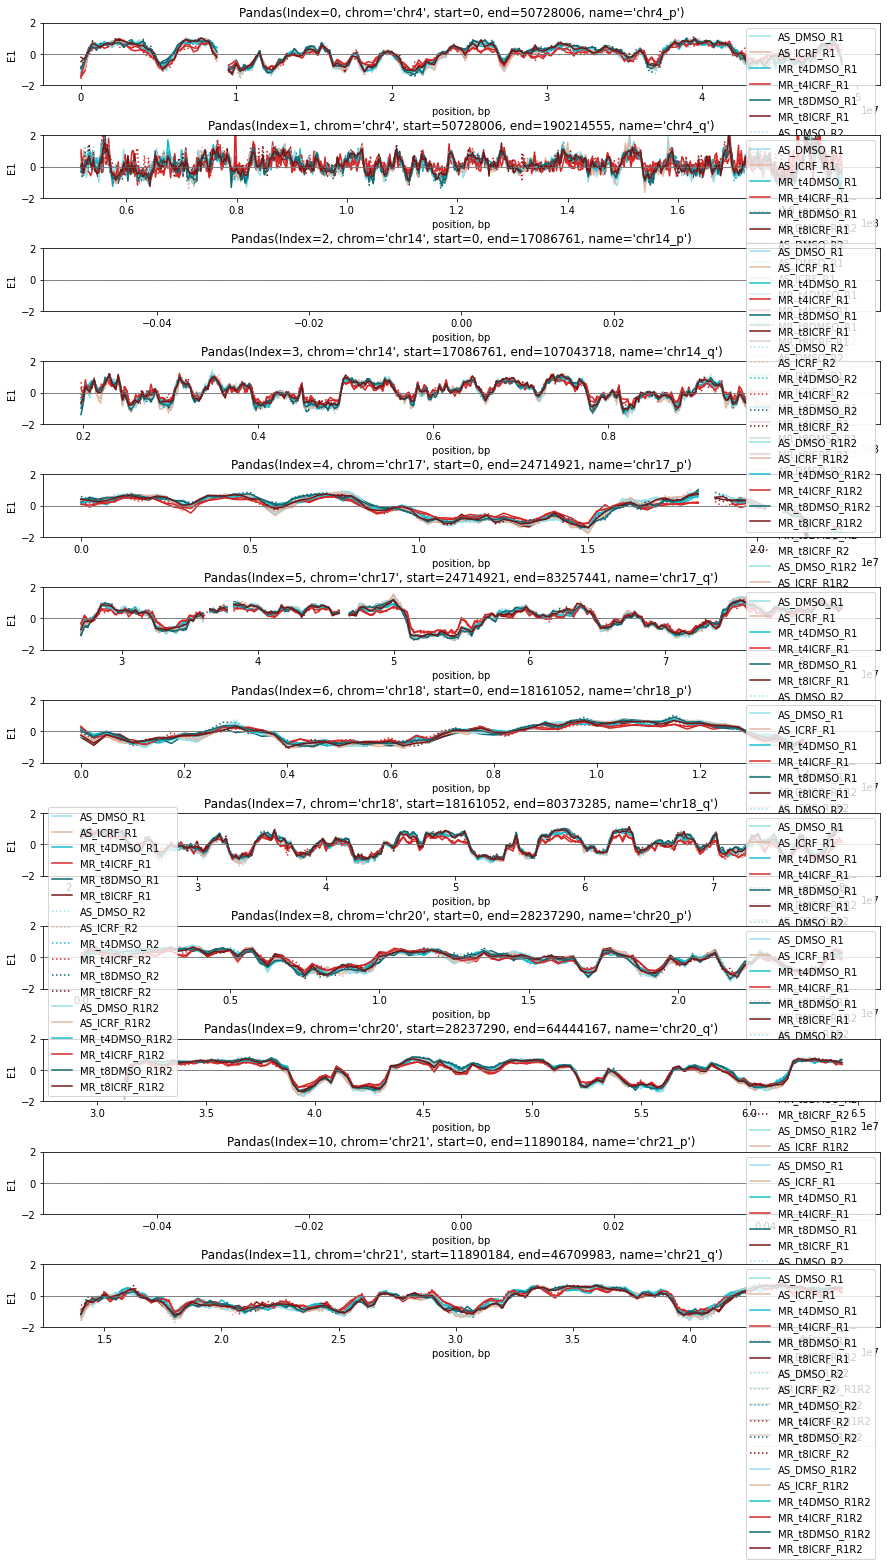

In [25]:
#plot eig1 for each region to make sure they were detecting compartments and not something else...
fig = plt.figure(figsize=(15, 2 * len(hg38_arms)))

gs1 = GridSpec(nrows = len(hg38_arms), ncols = 1, hspace = 0.8)

for i, arm in enumerate(hg38_arms.itertuples()):
    ax = plt.subplot(gs1[i])
    for cond in conditions:
        loc_eig = bioframe.select(eigs[cond], arm[1:4])
        ax.plot(
            loc_eig['start'],
            loc_eig['E1'],
            label = cond,
            color = sampleColors[cond],
            ls = sampleLineStyles[cond]
        )
        plt.axhline(0,ls='--',lw=0.5,color='gray')
        plt.ylabel('E1')
        plt.xlabel('position, bp')
        plt.title(arm)
        plt.legend()
        plt.ylim(-2, 2)

plt.savefig(f'{outDataDir}/figures/Eig1_250kb_byarm_mapq30.png', dpi = 300)

In [26]:
for cond in conditions:
    # Save text files
    eigs[cond].to_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.txt', sep='\t', index=False, na_rep = 'nan')
    
    # Save bedGraph track
    eigs[cond][['chrom', 'start', 'end', 'E1']].to_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.E1.bedGraph', sep='\t', index=False, na_rep = 'nan', header = False)
    # Save bigwig track
    bioframe.to_bigwig(eigs[cond], hg38_chromsizes, f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.E1.bw', 'E1')

In [27]:
#also run eigen decomposition on 100kb binned cooler files - for use with MC-3C data

In [28]:
#coolers - 100kb bins
binsize = 100000

clr_paths_100kb = {}
for cond in conditions:
    clr_paths_100kb[cond] = f'{outDataDir}/data/{long_names[cond]}.sampled.hg38.mapq_30.1000.mcool::resolutions/{binsize}'
    
clrs100kb = {
    cond: cooler.Cooler(clr_paths_100kb[cond]) for cond in conditions
}

In [29]:
good_chroms = ['chr4', 'chr14', 'chr17', 'chr18', 'chr20', 'chr21'] #For HeLa S3 datasets, limited to only chromosomes
#with minimal translocations. All chromosomes were used for HCT116 datasets.

In [30]:
bins = cooler.binnify(hg38_chromsizes, binsize)

In [31]:
from bioframe.io.resources import UCSCClient
mrna = UCSCClient('hg38').fetch_mrna()

In [32]:
genecov = bioframe.frac_gene_coverage(bins, mrna) 

In [33]:
genecov.head()

chrom   start     end  coverage  count
0  chr4       0  100000     36201    271
1  chr4  100000  200000     76225    318
2  chr4  200000  300000     80886    497
3  chr4  300000  400000    100000    554
4  chr4  400000  500000     99947    628

In [34]:
#Get compartments, flip based on gene density, good chroms by arm only
#Not sorting by variance compared to gene density, instead by variance explained of data

lam = {}
eigs = {}

for cond in conditions:
    lam[cond], eigs[cond] = cooltools.eigs_cis(
        clrs100kb[cond], 
        genecov,
        n_eigs=3, 
        ignore_diags=2,
        view_df = hg38_arms
    )

/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


In [35]:
for cond in conditions:
    # Save text files
    lam[cond].to_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.lam.txt', sep='\t')


In [36]:
hg38_arms.head()

chrom     start        end     name
0   chr4         0   50728006   chr4_p
1   chr4  50728006  190214555   chr4_q
2  chr14         0   17086761  chr14_p
3  chr14  17086761  107043718  chr14_q
4  chr17         0   24714921  chr17_p

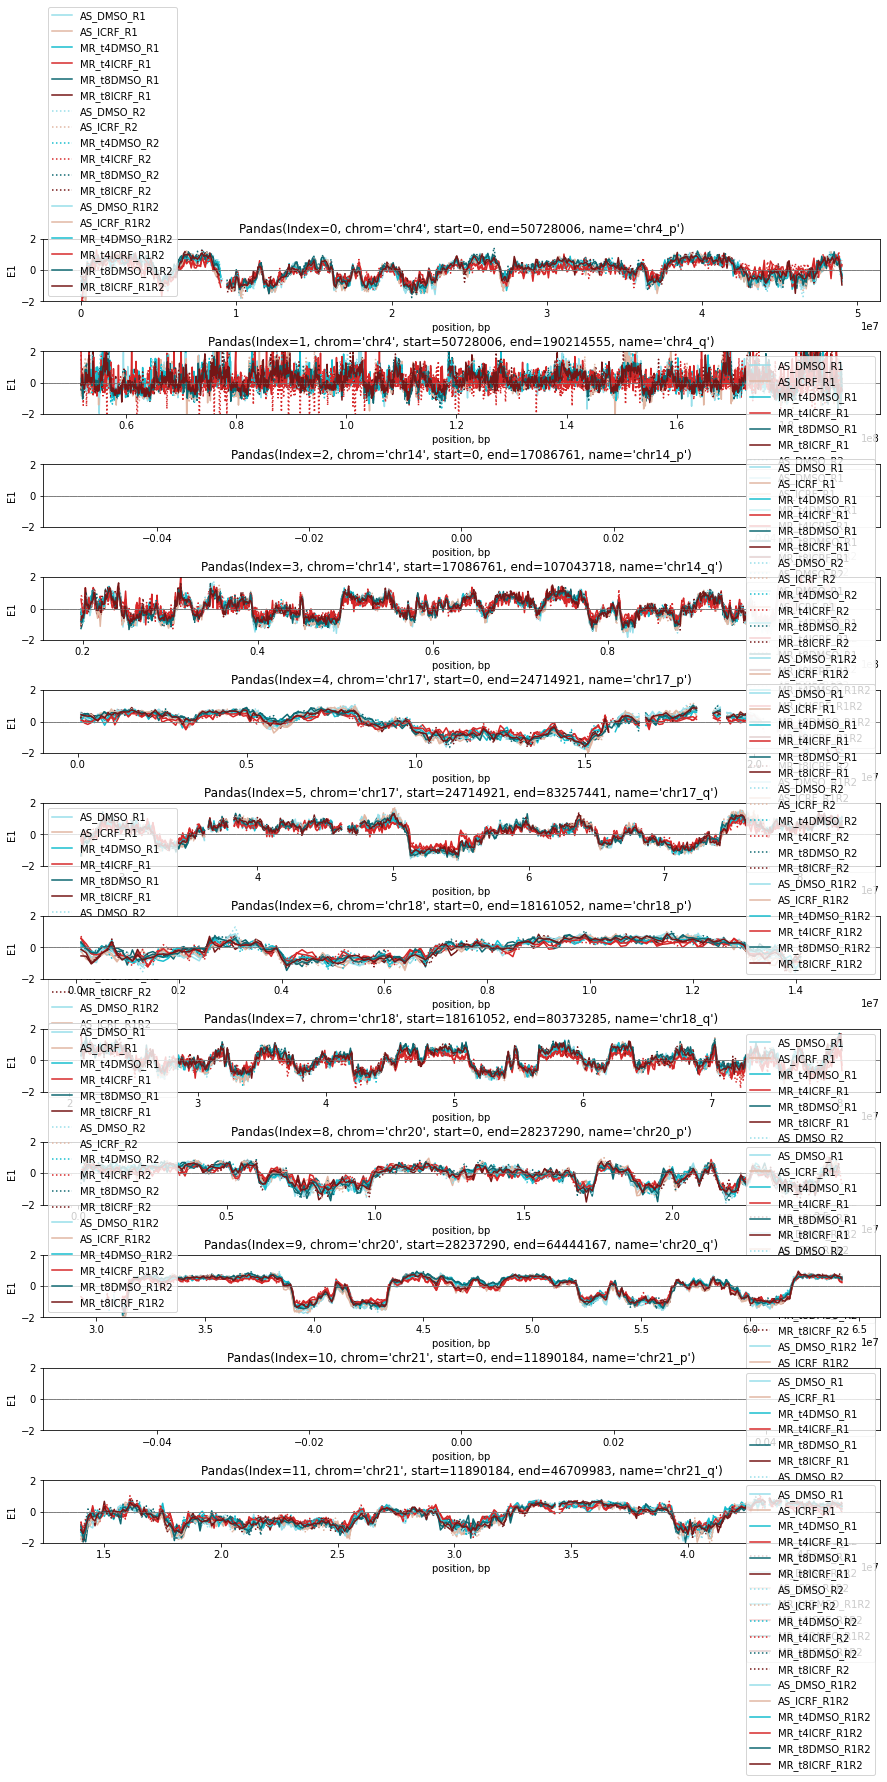

In [37]:
#plot eig1 for each region to make sure they were detecting compartments correctly by visual inspection
fig = plt.figure(figsize=(15, 2 * len(hg38_arms)))

gs1 = GridSpec(nrows = len(hg38_arms), ncols = 1, hspace = 0.8)

for i, arm in enumerate(hg38_arms.itertuples()):
    ax = plt.subplot(gs1[i])
    for cond in conditions:
        loc_eig = bioframe.select(eigs[cond], arm[1:4])
        ax.plot(
            loc_eig['start'],
            loc_eig['E1'],
            label = cond,
            color = sampleColors[cond],
            ls = sampleLineStyles[cond]
        )
        plt.axhline(0,ls='--',lw=0.5,color='gray')
        plt.ylabel('E1')
        plt.xlabel('position, bp')
        plt.title(arm)
        plt.legend()
        plt.ylim(-2, 2)

plt.savefig(f'{outDataDir}/figures/Eig1_100kb_byarm_mapq30.png', dpi = 300)

In [38]:
for cond in conditions:
    # Save text files
    eigs[cond].to_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.txt', sep='\t', index=False, na_rep = 'nan')
    
    # Save bedGraph track
    eigs[cond][['chrom', 'start', 'end', 'E1']].to_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.E1.bedGraph', sep='\t', index=False, na_rep = 'nan', header = False)
    # Save bigwig track
    bioframe.to_bigwig(eigs[cond], hg38_chromsizes, f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.E1.bw', 'E1')

In [39]:
#Set binsize back to 250kb for plotting heatmaps with eigen 1
binsize = 250000

In [40]:
eigs = {}
for cond in conditions:
    eigs[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.txt', sep = '\t')

In [41]:
import cooltools.lib.plotting

In [42]:
ComboConds_Async = [
    'AS_DMSO_R1R2',
    'AS_ICRF_R1R2',
]

/tmp/ipykernel_2892575/2776549111.py:40: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),
/tmp/ipykernel_2892575/2776549111.py:40: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),


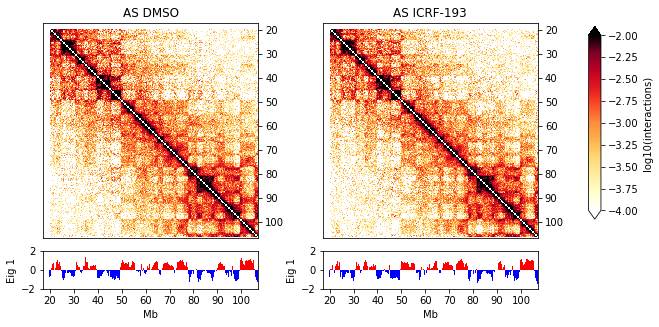

In [43]:
plottingregion = 'chr14:17086761-107043718'
chromarm = ('chr14', 17086761, 107043718)

opts = dict(
    vmin=-4, #change scale range here
    vmax=-2,
    cmap='fall'
)

fig = plt.figure(figsize=((4.5 * 2) + 1, 5))

gs00 = GridSpec(nrows = 1, ncols = 2, width_ratios = [20*2] + [1], wspace=0.2)

gs_cb = GridSpecFromSubplotSpec(nrows=2, ncols=1, height_ratios=[6, 1], wspace = 0.1, subplot_spec = gs00[1])

#how many heatmaps
gs0 = GridSpecFromSubplotSpec(nrows=1, ncols=2, wspace = 0.3, subplot_spec = gs00[0])

for i, cond in enumerate(ComboConds_Async):
    gs1 = GridSpecFromSubplotSpec(nrows = 2, ncols = 1, height_ratios=[6, 1], wspace=0.1, 
                                  hspace = 0.05, subplot_spec = gs0[i])

    c = clrs250kb[cond]
    cis = c.matrix(balance = True).fetch(plottingregion)
    
    n,j = np.indices(cis.shape)
    n = n.flatten()
    j = j.flatten()
    # fill NaNs inside of the desired selection:
    nan_band_selector = (np.abs(n-j) < 2) #fills 2 bins on diagonal with nan
    cis[n[nan_band_selector],j[nan_band_selector]] = np.nan
    
    cisbins = c.bins().fetch(plottingregion)
    mids = cisbins['end'] - binsize/2
    mids = mids.reset_index(drop=True)
    
    #plot heatmap
    ax = plt.subplot(gs1[0, 0])
    img = ax.matshow( #can change this to plt.imshow instead probably?
        np.log10(cis), 
        extent=[
            mids[0]/1000000, 
            mids.iloc[-1]/1000000, 
            mids.iloc[-1]/1000000, 
            mids[0]/1000000], 
        **opts)
    ax.xaxis.set_visible(False)
    ax.yaxis.tick_right()    
    ax.set_aspect('equal')
    plt.title(samplePlotNames[cond])
    
    # barplot of eigenvalues

    ax1 = plt.subplot(gs1[1, 0])
    plt.ylim(-2, 2) 
    plt.xlim(chromarm[1]/1000000, chromarm[2]/1000000)
    img2 = ax1.bar(
        x = list((eigs[cond][eigs[cond].chrom == chromarm[0]]['start'] + binsize/2)/1000000), 
        height = list(eigs[cond][eigs[cond].chrom == chromarm[0]]['E1']),
        width = 0.25,
        color=eigs[cond].E1[eigs[cond].chrom == chromarm[0]].apply(lambda x: 'r' if x>0 else 'b')
                  )
    plt.ylabel('Eig 1')
    plt.xlabel('Mb')
    ax1.xaxis.set_ticks(np.arange(20, 110, 10)) #This specifically sets ticks to this range, to match y axis
    fig.add_subplot(ax1)
    
# color bar in it's own axis, and own gridspace
    colorAx = plt.subplot(gs_cb[0, 0])
    cb = plt.colorbar(img, cax = colorAx, extend = 'both')
    cb.set_label('log10(interactions)')

#plt.suptitle(f'Chr14 Heatmaps and Eigen1 200kb Bins')
plt.savefig("{}/figures/ASG1Sort_R1R2Combined_FullChr14Heatmaps_250kbBins_MinusDiag_WithEigen1_Barplot_columns.png".format(outDataDir), dpi = 300, bbox_inches = 'tight')

In [44]:
ComboConds_MR = [
    'MR_t4DMSO_R1R2',
    'MR_t4ICRF_R1R2',
    'MR_t8DMSO_R1R2',
    'MR_t8ICRF_R1R2',
]

/tmp/ipykernel_2892575/893002764.py:39: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),
/tmp/ipykernel_2892575/893002764.py:39: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),
/tmp/ipykernel_2892575/893002764.py:39: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),
/tmp/ipykernel_2892575/893002764.py:39: RuntimeWarning: divide by zero encountered in log10
  np.log10(cis),


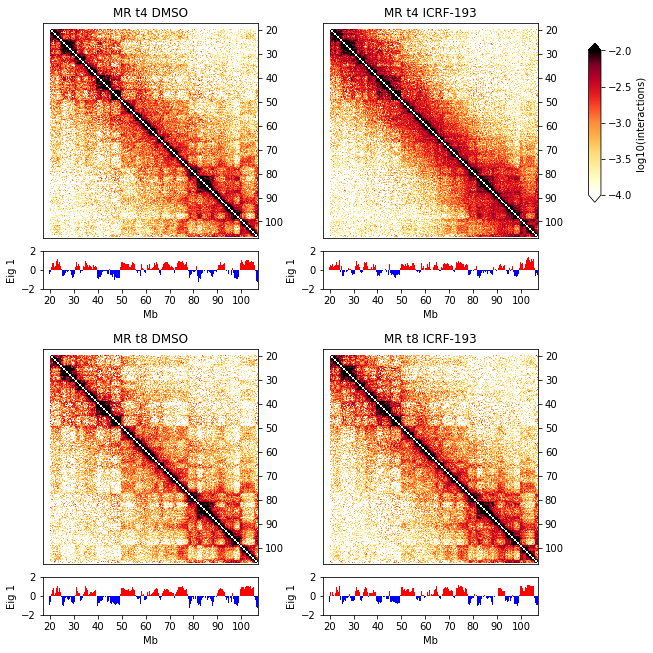

In [45]:
plottingregion = 'chr14:17086761-107043718'
chromarm = ('chr14', 17086761, 107043718)

opts = dict(
    vmin=-4, #change scale range here
    vmax=-2,
    cmap='fall'
)

fig = plt.figure(figsize=((4.5 * 2) + 1, 11))

gs00 = GridSpec(nrows = 1, ncols = 2, width_ratios = [20*2] + [1], wspace=0.2)
gs_cb1 = GridSpecFromSubplotSpec(nrows=2, ncols=1, subplot_spec = gs00[1])
gs_cb = GridSpecFromSubplotSpec(nrows=2, ncols=1, height_ratios=[6, 1], wspace = 0.1, subplot_spec = gs_cb1[0])

#how many heatmaps
gs0 = GridSpecFromSubplotSpec(nrows=2, ncols=2, wspace = 0.3, subplot_spec = gs00[0])

for i, cond in enumerate(ComboConds_MR):
    gs1 = GridSpecFromSubplotSpec(nrows = 2, ncols = 1, height_ratios=[6, 1], wspace=0.1, hspace = 0.05, subplot_spec = gs0[i])

    c = clrs250kb[cond]
    cis = c.matrix(balance = True).fetch(plottingregion)
    
    n,j = np.indices(cis.shape)
    n = n.flatten()
    j = j.flatten()
    # fill NaNs inside of the desired selection:
    nan_band_selector = (np.abs(n-j) < 2) #fills 2 bins on diagonal with nan
    cis[n[nan_band_selector],j[nan_band_selector]] = np.nan
    
    cisbins = c.bins().fetch(plottingregion)
    mids = cisbins['end'] - binsize/2
    mids = mids.reset_index(drop=True)
    
    #plot heatmap
    ax = plt.subplot(gs1[0, 0])
    img = ax.matshow( #can change this to plt.imshow instead probably?
        np.log10(cis), 
        extent=[
            mids[0]/1000000, 
            mids.iloc[-1]/1000000, 
            mids.iloc[-1]/1000000, 
            mids[0]/1000000], 
        **opts)
    ax.xaxis.set_visible(False)
    ax.yaxis.tick_right()    
    ax.set_aspect('equal')
    plt.title(samplePlotNames[cond])
    
    # barplot of eigenvalues

    ax1 = plt.subplot(gs1[1, 0])
    plt.ylim(-2, 2) 
    plt.xlim(chromarm[1]/1000000, chromarm[2]/1000000)
    img2 = ax1.bar(
        x = list((eigs[cond][eigs[cond].chrom == chromarm[0]]['start'] + binsize/2)/1000000), 
        height = list(eigs[cond][eigs[cond].chrom == chromarm[0]]['E1']),
        width = 0.25,
        color=eigs[cond].E1[eigs[cond].chrom == chromarm[0]].apply(lambda x: 'r' if x>0 else 'b')
                  )
    plt.ylabel('Eig 1')
    plt.xlabel('Mb')
    ax1.xaxis.set_ticks(np.arange(20, 110, 10)) #This specifically sets ticks to this range, to match y axis
    fig.add_subplot(ax1)
    
# color bar in it's own axis, and own gridspace
    colorAx = plt.subplot(gs_cb[0, 0])
    cb = plt.colorbar(img, cax = colorAx, extend = 'both')
    cb.set_label('log10(interactions)')

#plt.suptitle(f'Chr14 Heatmaps and Eigen1 200kb Bins')
plt.savefig("{}/figures/MRG1Sort_R1R2Combined_FullChr14Heatmaps_250kbBins_MinusDiag_WithEigen1_Barplot_columns.png".format(outDataDir), dpi = 300, bbox_inches = 'tight')

In [46]:
#Log10 ratio heatmap

In [47]:
AS_ComboCtrlConds = ['AS_DMSO_R1R2']
AS_ComboTreatConds = ['AS_ICRF_R1R2']

/tmp/ipykernel_2892575/3499035828.py:23: RuntimeWarning: divide by zero encountered in log10
  treatLog10 = np.log10(treatcis)
/tmp/ipykernel_2892575/3499035828.py:30: RuntimeWarning: divide by zero encountered in log10
  dmsoLog10 = np.log10(dmsocis)
/tmp/ipykernel_2892575/3499035828.py:32: RuntimeWarning: invalid value encountered in subtract
  ratiocis = treatLog10-dmsoLog10


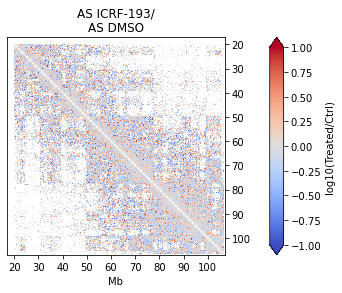

In [48]:
#ratios for main figure - R1 + R2 combined only, 100kb bins
plottingregion = 'chr14:17086761-107043718'
chromarm = ('chr14', 17086761, 107043718)

opts = dict(
    vmin=-1,
    vmax=1,
    cmap='coolwarm'
)

fig = plt.figure(figsize=(4.5 + 1, 4))

gs00 = GridSpec(nrows = 1, ncols = 2, width_ratios = [20*1] + [1], wspace=0.1)
gs0 = GridSpecFromSubplotSpec(nrows=1, ncols=1, wspace = 0.3, subplot_spec = gs00[0])

for i, (DMSOcond, Treatcond) in enumerate(zip(AS_ComboCtrlConds, AS_ComboTreatConds)):
    
    treatc = clrs250kb[Treatcond]
    treatcis = treatc.matrix(balance = True).fetch(plottingregion)
    treatcisbins = treatc.bins().fetch(plottingregion)
    treatmids = treatcisbins['end'] - binsize/2
    treatmids = treatmids.reset_index(drop=True)
    treatLog10 = np.log10(treatcis)
    
    dmsoc = clrs250kb[DMSOcond]
    dmsocis = dmsoc.matrix(balance = True).fetch(plottingregion)
    dmsocisbins = dmsoc.bins().fetch(plottingregion)
    dmsomids = dmsocisbins['end'] - binsize/2
    dmsomids = dmsomids.reset_index(drop=True)
    dmsoLog10 = np.log10(dmsocis)
    
    ratiocis = treatLog10-dmsoLog10
    k,j = np.indices(ratiocis.shape)
    k = k.flatten()
    j = j.flatten()
    # fill NaNs inside of the desired selection:
    nan_band_selector = (np.abs(k-j) < 2) #fills 2 bins on diagonal with nan
    ratiocis[k[nan_band_selector],j[nan_band_selector]] = np.nan
    
    ax = plt.subplot(gs0[i])
    img = ax.matshow(
        ratiocis, extent=[treatmids[0]/1000000, treatmids.iloc[-1]/1000000, treatmids.iloc[-1]/1000000, treatmids[0]/1000000], 
        **opts)
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_right() 
    plt.title(samplePlotNames[Treatcond] + '/\n' + samplePlotNames[DMSOcond])
    plt.xlabel('Mb')
    ax.set_aspect('equal')
    
# color bar in it's own axis, and own gridspace
colorAx = plt.subplot(gs00[1])
cb = plt.colorbar(img, cax = colorAx, extend = 'both')
cb.set_label('log10(Treated/Ctrl)')

plt.savefig("{}/figures/ASICRFG1Sort_R1R2Combined_Chr14RatioHeatmaps_minusdiag_250KbBins.png".format(outDataDir), dpi = 300, bbox_inches = 'tight')

In [49]:
MR_ComboCtrlConds = ['MR_t4DMSO_R1R2', 'MR_t8DMSO_R1R2']
MR_ComboTreatConds = ['MR_t4ICRF_R1R2', 'MR_t8ICRF_R1R2']

/tmp/ipykernel_2892575/1816066180.py:25: RuntimeWarning: divide by zero encountered in log10
  treatLog10 = np.log10(treatcis)
/tmp/ipykernel_2892575/1816066180.py:32: RuntimeWarning: divide by zero encountered in log10
  dmsoLog10 = np.log10(dmsocis)
/tmp/ipykernel_2892575/1816066180.py:34: RuntimeWarning: invalid value encountered in subtract
  ratiocis = treatLog10-dmsoLog10
/tmp/ipykernel_2892575/1816066180.py:25: RuntimeWarning: divide by zero encountered in log10
  treatLog10 = np.log10(treatcis)
/tmp/ipykernel_2892575/1816066180.py:32: RuntimeWarning: divide by zero encountered in log10
  dmsoLog10 = np.log10(dmsocis)
/tmp/ipykernel_2892575/1816066180.py:34: RuntimeWarning: invalid value encountered in subtract
  ratiocis = treatLog10-dmsoLog10


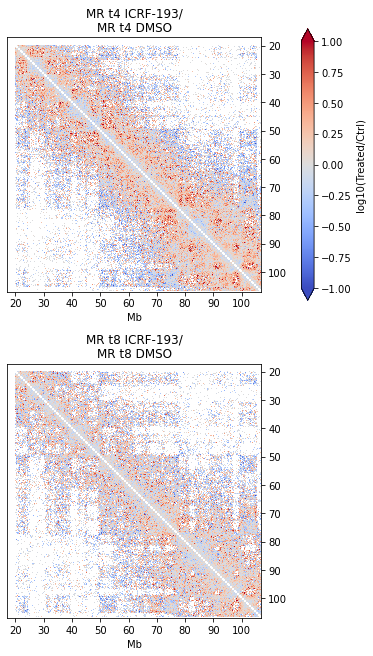

In [50]:
#ratios for main figure - R1 + R2 combined only, 100kb bins
plottingregion = 'chr14:17086761-107043718'
chromarm = ('chr14', 17086761, 107043718)

opts = dict(
    vmin=-1,
    vmax=1,
    cmap='coolwarm'
)

fig = plt.figure(figsize=(4.5 + 1, 11))

gs00 = GridSpec(nrows = 1, ncols = 2, width_ratios = [20*1] + [1], wspace=0.3)
gs0 = GridSpecFromSubplotSpec(nrows=2, ncols=1, wspace = 0.3, subplot_spec = gs00[0])

gs_cb1 = GridSpecFromSubplotSpec(nrows=2, ncols=1, subplot_spec = gs00[1], wspace = 0.3)                 

for i, (DMSOcond, Treatcond) in enumerate(zip(MR_ComboCtrlConds, MR_ComboTreatConds)):
    
    treatc = clrs250kb[Treatcond]
    treatcis = treatc.matrix(balance = True).fetch(plottingregion)
    treatcisbins = treatc.bins().fetch(plottingregion)
    treatmids = treatcisbins['end'] - binsize/2
    treatmids = treatmids.reset_index(drop=True)
    treatLog10 = np.log10(treatcis)
    
    dmsoc = clrs250kb[DMSOcond]
    dmsocis = dmsoc.matrix(balance = True).fetch(plottingregion)
    dmsocisbins = dmsoc.bins().fetch(plottingregion)
    dmsomids = dmsocisbins['end'] - binsize/2
    dmsomids = dmsomids.reset_index(drop=True)
    dmsoLog10 = np.log10(dmsocis)
    
    ratiocis = treatLog10-dmsoLog10
    k,j = np.indices(ratiocis.shape)
    k = k.flatten()
    j = j.flatten()
    # fill NaNs inside of the desired selection:
    nan_band_selector = (np.abs(k-j) < 2) #fills 2 bins on diagonal with nan
    ratiocis[k[nan_band_selector],j[nan_band_selector]] = np.nan
    
    ax = plt.subplot(gs0[i])
    img = ax.matshow(
        ratiocis, extent=[treatmids[0]/1000000, treatmids.iloc[-1]/1000000, treatmids.iloc[-1]/1000000, treatmids[0]/1000000], 
        **opts)
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_right() 
    plt.title(samplePlotNames[Treatcond] + '/\n' + samplePlotNames[DMSOcond])
    plt.xlabel('Mb')
    ax.set_aspect('equal')
    
# color bar in it's own axis, and own gridspace
colorAx = plt.subplot(gs_cb1[0])
cb = plt.colorbar(img, cax = colorAx, extend = 'both')
cb.set_label('log10(Treated/Ctrl)')

plt.savefig("{}/figures/MRICRFG1Sort_R1R2Combined_Chr14RatioHeatmaps_minusdiag_250KbBins.png".format(outDataDir), dpi = 300, bbox_inches = 'tight')

In [51]:
#Saddleplots and strength with own eig1

In [54]:
#coolers - 250kb bins
binsize = 250000

clr_paths_250kb = {}
for cond in conditions:
    clr_paths_250kb[cond] = f'{outDataDir}/data/{long_names[cond]}.sampled.hg38.mapq_30.1000.mcool::resolutions/{binsize}'
    
clrs250kb = {
    cond: cooler.Cooler(clr_paths_250kb[cond]) for cond in conditions
}

In [55]:
#need to filter out arms without any data - from gfudenberg (https://github.com/open2c/cooltools/issues/330)
bins = clrs250kb['MR_t8DMSO_R1R2'].bins()[:].copy()
bins['coverage'] = cooltools.coverage(clrs250kb['MR_t8DMSO_R1R2'])[1]
bins

chrom     start       end    weight  coverage
0      chr1         0    250000       NaN      78.0
1      chr1    250000    500000       NaN       3.0
2      chr1    500000    750000       NaN       5.0
3      chr1    750000   1000000  0.020167    3504.0
4      chr1   1000000   1250000  0.010615    6445.0
...     ...       ...       ...       ...       ...
12362  chrY  56250000  56500000       NaN       0.0
12363  chrY  56500000  56750000       NaN       0.0
12364  chrY  56750000  57000000  0.262602     212.0
12365  chrY  57000000  57227415       NaN       0.0
12366  chrM         0     16569  0.001997   28218.0

[12367 rows x 5 columns]

In [56]:
view_coverage = bioframe.overlap(hg38_arms, bins).groupby('name').sum('coverage_')
view_coverage

start           end       start_         end_    weight_  \
name                                                                      
chr14_p            0    1178986509    586500000    603750000   0.000000   
chr14_q   6168320721   38642782198  22382000000  22472043718   6.573880   
chr17_p            0    2446777179   1212750000   1237500000   1.512325   
chr17_q   5832721356   19648756076  12714500000  12773257441   3.674932   
chr18_p            0    1325756796    657000000    675250000   1.128213   
chr18_q   4540263000   20093321250  12281250000  12343623285   4.517025   
chr20_p            0    3190813770   1582000000   1610250000   2.313012   
chr20_q   4122644340    9408848382   6734250000   6770694167   1.742185   
chr21_p            0     570728832    282000000    294000000   0.000000   
chr21_q   1664625760    6539397620   4077500000   4112459983   2.747684   
chr4_p             0   10297785218   5125750000   5176500000   4.647871   
chr4_q   28356955354  106329936245  67219750000  67359464555  15.018378   

         coverage_  
name                
chr14_p       41.0  
chr14_q  1179547.0  
chr17_p   315347.0  
chr17_q   900716.0  
chr18_p   188500.0  
chr18_q   744131.0  
chr20_p   254750.0  
chr20_q   808370.0  
chr21_p     1848.0  
chr21_q   395459.0  
chr4_p    436776.0  
chr4_q    942326.0

In [57]:
view_coverage['coverage_'].values > 1e4

array([False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True])

In [59]:
hg38_arms_filtered = bioframe.make_viewframe(hg38_arms[hg38_arms['name'].isin(view_coverage[view_coverage['coverage_'].values > 1e4].index)])

In [60]:
hg38_arms_filtered

chrom     start        end     name
0    chr4         0   50728006   chr4_p
1    chr4  50728006  190214555   chr4_q
3   chr14  17086761  107043718  chr14_q
4   chr17         0   24714921  chr17_p
5   chr17  24714921   83257441  chr17_q
6   chr18         0   18161052  chr18_p
7   chr18  18161052   80373285  chr18_q
8   chr20         0   28237290  chr20_p
9   chr20  28237290   64444167  chr20_q
11  chr21  11890184   46709983  chr21_q

In [61]:
hg38_arms_filtered.to_csv(f'{outDataDir}/data/hg38_arms_filtered.bed', index = False, header = None, sep = '\t')

In [62]:
for cond in conditions:
    in_fname = clr_paths_250kb[cond]
    region_fname = f'{outDataDir}/data/hg38_arms_filtered.bed'
    out_fname = f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.tsv'
    !bsub -q short -W 01:00 -e /lsf_jobs/LSB_%J.err -o /lsf_jobs/LSB_%J.log \
        -n 4 -R span[hosts=1] -R select[ib] -R rusage[mem=4000] -R select[rh=8] \
        "cooltools expected-cis -p 4 -o $out_fname --clr-weight-name weight --ignore-diags 2 $in_fname --regions $region_fname"


Job <8233388> is submitted to queue <short>.
Job <8233393> is submitted to queue <short>.
Job <8233398> is submitted to queue <short>.
Job <8233402> is submitted to queue <short>.
Job <8233408> is submitted to queue <short>.
Job <8233413> is submitted to queue <short>.
Job <8233418> is submitted to queue <short>.
Job <8233423> is submitted to queue <short>.
Job <8233428> is submitted to queue <short>.
Job <8233433> is submitted to queue <short>.
Job <8233438> is submitted to queue <short>.
Job <8233443> is submitted to queue <short>.
Job <8233448> is submitted to queue <short>.
Job <8233453> is submitted to queue <short>.
Job <8233458> is submitted to queue <short>.
Job <8233463> is submitted to queue <short>.
Job <8233468> is submitted to queue <short>.
Job <8233472> is submitted to queue <short>.


In [63]:
#Saddle strength - AA, BB, AA + BB

In [64]:
#AA vs BB compartment scores
def saddle_strengthAB(S, C):
    """
    Parameters
    ----------
    S, C : 2D arrays, square, same shape
        Saddle sums and counts, respectively
        
    Returns
    -------
    2x1D array
    Ratios of cumulative corner interaction scores, where the saddle data is 
    separately AA/AB and BB/BA corners with increasing extent
    
    """
    m, n = S.shape
    if m != n:
        raise ValueError("`saddledata` should be square.")

    ratiosA = np.zeros(n)
    for k in range(1, n):
        intra_sumA = S[n-k:n, n-k:n].sum() 
        intra_countA = C[n-k:n, n-k:n].sum()
        intraA = intra_sumA / intra_countA
        
        inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
        inter_count =  C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
        inter = inter_sum / inter_count
        
        ratiosA[k] = intraA / inter
        
    ratiosB = np.zeros(n)
    for k in range(1, n):
        intra_sumB = S[0:k, 0:k].sum()
        intra_countB = C[0:k, 0:k].sum()
        intraB = intra_sumB / intra_countB
        
        inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
        inter_count =  C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
        inter = inter_sum / inter_count
        
        ratiosB[k] = intraB / inter
    
    ratios = {
        'A' : ratiosA,
        'B' : ratiosB
    }
    
    return ratios

In [65]:
# use this if expected already run, will be much faster
cis_exp = {}

for cond in conditions:
    cis_exp[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.tsv', sep='\t')

In [66]:
cis_exp[cond] 

region1  region2  dist  n_valid  count.sum  balanced.sum   count.avg  \
0      chr4_p   chr4_p     0      195        NaN           NaN         NaN   
1      chr4_p   chr4_p     1      193        NaN           NaN         NaN   
2      chr4_p   chr4_p     2      191    21974.0     10.515006  115.047120   
3      chr4_p   chr4_p     3      190    12643.0      6.348844   66.542105   
4      chr4_p   chr4_p     4      189     8318.0      4.199064   44.010582   
...       ...      ...   ...      ...        ...           ...         ...   
2175  chr21_q  chr21_q   135        0        0.0      0.000000         NaN   
2176  chr21_q  chr21_q   136        0        0.0      0.000000         NaN   
2177  chr21_q  chr21_q   137        0        0.0      0.000000         NaN   
2178  chr21_q  chr21_q   138        0        0.0      0.000000         NaN   
2179  chr21_q  chr21_q   139        0        0.0      0.000000         NaN   

      balanced.avg  
0              NaN  
1              NaN  
2         0.055052  
3         0.033415  
4         0.022217  
...            ...  
2175           NaN  
2176           NaN  
2177           NaN  
2178           NaN  
2179           NaN  

[2180 rows x 8 columns]

In [67]:
eigs = {}
for cond in conditions:
    eigs[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.byarm.eigs.cis.vecs.txt', sep = '\t')


In [68]:
eigs[cond]

chrom     start       end    weight  E1  E2  E3
0      chr1         0    250000       NaN NaN NaN NaN
1      chr1    250000    500000       NaN NaN NaN NaN
2      chr1    500000    750000       NaN NaN NaN NaN
3      chr1    750000   1000000  0.021648 NaN NaN NaN
4      chr1   1000000   1250000  0.010588 NaN NaN NaN
...     ...       ...       ...       ...  ..  ..  ..
12362  chrY  56250000  56500000       NaN NaN NaN NaN
12363  chrY  56500000  56750000       NaN NaN NaN NaN
12364  chrY  56750000  57000000  0.287520 NaN NaN NaN
12365  chrY  57000000  57227415       NaN NaN NaN NaN
12366  chrM         0     16569  0.001723 NaN NaN NaN

[12367 rows x 7 columns]

In [69]:
#Saddle strength by distance

In [70]:
#make bands - changed distances to be doubling for each bin

#make bands
binsize=250000

bandedges = np.array([0, 20000000, 80000000])
bands = list(zip(bandedges[:-1],bandedges[1:]))
print('bands in bp')
for band in bands:
    print(band)
bands = list(zip((bandedges[:-1]/binsize).astype(int), \
                 (bandedges[1:]/binsize).astype(int)))
print('bands in bins')
new_bands = []
for band in bands:
    if band[0] == 0:
        new_bands.append((3, band[1]))
    else:
        new_bands.append((band[0] + 1, band[1]))
        
for band in new_bands:
    print(band)
    
bands = new_bands

bands in bp
(0, 20000000)
(20000000, 80000000)
bands in bins
(3, 80)
(81, 320)


In [71]:
bands

[(3, 80), (81, 320)]

In [72]:
#Strength by band for own eig1

In [73]:
#Use the function to return saddledata for each band size (just good chromosomes, by arm)

sumsBands_ownE1 = {}
countsBands_ownE1 = {}

for cond in conditions:
    sumsBands_ownE1[cond] = {}
    countsBands_ownE1[cond] = {}
    for band in bands:
        sumsBands_ownE1[cond][band], countsBands_ownE1[cond][band] = cooltools.api.saddle.saddle(
            clr = clrs250kb[cond], 
            expected = cis_exp[cond], 
            contact_type = 'cis',
            view_df = hg38_arms_filtered.reset_index(drop = True), #why is this needed? doesn't work without resetting index?
            min_diag = band[0],
            max_diag = band[1],
            track = eigs[cond][['chrom', 'start', 'end', 'E1']],
            qrange = (0.02, 0.98),
            n_bins = 50,
            verbose = False
        )

/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarnin

/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/api/saddle.py:89: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarnin

In [74]:
#Compartment strength - AA vs BB, by distance band

In [75]:
#Own Eig1

In [76]:
#AA vs BB strength
strengthABBands_ownE1 = {}
for cond in conditions:
    strengthABBands_ownE1[cond] = {}
    for band in bands:
        strengthABBands_ownE1[cond][band] = saddle_strengthAB(sumsBands_ownE1[cond][band], countsBands_ownE1[cond][band])

/tmp/ipykernel_2892575/2166326075.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  ratiosA[k] = intraA / inter
/tmp/ipykernel_2892575/2166326075.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  ratiosB[k] = intraB / inter
/tmp/ipykernel_2892575/2166326075.py:28: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count
/tmp/ipykernel_2892575/2166326075.py:40: RuntimeWarning: invalid value encountered in double_scalars
  inter = inter_sum / inter_count


In [77]:
SepTreatConds

['AS_ICRF_R1',
 'MR_t8DMSO_R1',
 'MR_t4ICRF_R1',
 'MR_t8ICRF_R1',
 'AS_ICRF_R2',
 'MR_t8DMSO_R2',
 'MR_t4ICRF_R2',
 'MR_t8ICRF_R2']

In [78]:
SepCtrlConds

['AS_DMSO_R1',
 'MR_t4DMSO_R1',
 'MR_t4DMSO_R1',
 'MR_t8DMSO_R1',
 'AS_DMSO_R2',
 'MR_t4DMSO_R2',
 'MR_t4DMSO_R2',
 'MR_t8DMSO_R2']

In [79]:
#log2 ratio of treatment/control saddle strength within each replicate
sep_log2_treatvsctrl_bands = {}
for comp in ['A', 'B']:
    sep_log2_treatvsctrl_bands[comp] = {}
    for treat, ctrl in zip(SepTreatConds, SepCtrlConds):
        sep_log2_treatvsctrl_bands[comp][f'{treat}vs{ctrl}'] = {}
        for band in bands:
            sep_log2_treatvsctrl_bands[comp][f'{treat}vs{ctrl}'][band] = np.log2(strengthABBands_ownE1[treat][band][comp]) - np.log2(strengthABBands_ownE1[ctrl][band][comp])
        

/tmp/ipykernel_2892575/3223837063.py:8: RuntimeWarning: divide by zero encountered in log2
  sep_log2_treatvsctrl_bands[comp][f'{treat}vs{ctrl}'][band] = np.log2(strengthABBands_ownE1[treat][band][comp]) - np.log2(strengthABBands_ownE1[ctrl][band][comp])
/tmp/ipykernel_2892575/3223837063.py:8: RuntimeWarning: invalid value encountered in subtract
  sep_log2_treatvsctrl_bands[comp][f'{treat}vs{ctrl}'][band] = np.log2(strengthABBands_ownE1[treat][band][comp]) - np.log2(strengthABBands_ownE1[ctrl][band][comp])


In [80]:
#Plot bargraph of avg and dots of replicates log2(treat/ctrl) for AA and BB comp strength by band
#10 bin square - top 20% A or B

comp_score_df = pd.DataFrame(columns = ['Comparison', 'Compartment', 'Replicate', 'Label', 'Score'])

repdict = {
    'AS_DMSO_R1' : 'R1',
    'AS_ICRF_R1' : 'R1',
    'MR_t4DMSO_R1' : 'R1',
    'MR_t4ICRF_R1' : 'R1',
    'MR_t8DMSO_R1' : 'R1',
    'MR_t8ICRF_R1' : 'R1',
    'AS_DMSO_R2' : 'R2',
    'AS_ICRF_R2' : 'R2',
    'MR_t4DMSO_R2' : 'R2',
    'MR_t4ICRF_R2' : 'R2',
    'MR_t8DMSO_R2' : 'R2',
    'MR_t8ICRF_R2' : 'R2',
}

labeldict = {
    'AS_DMSO_R1' : 'AS DMSO',
    'AS_ICRF_R1' : 'AS ICRF-193',
    'MR_t4DMSO_R1' : 'MR t4 DMSO',
    'MR_t4ICRF_R1' : 'MR t4 ICRF-193',
    'MR_t8DMSO_R1' : 'MR t8 DMSO',
    'MR_t8ICRF_R1' : 'MR t8 ICRF-193',
    'AS_DMSO_R2' : 'AS DMSO',
    'AS_ICRF_R2' : 'AS ICRF-193',
    'MR_t4DMSO_R2' : 'MR t4 DMSO',
    'MR_t4ICRF_R2' : 'MR t4 ICRF-193',
    'MR_t8DMSO_R2' : 'MR t8 DMSO',
    'MR_t8ICRF_R2': 'MR t8 ICRF-193',
}

labelPlotColors = {
    'AS DMSO' : '#98DFEA',
    'AS ICRF-193' :  '#E1B7A3',
    'MR t4 DMSO' : '#17BECF',
    'MR t4 ICRF-193' : '#D62728',    
    'MR t8 DMSO' : '#0D6871',
    'MR t8 ICRF-193' : '#751616',    
}

In [81]:
#Plot bargraph of avg and dots of replicates log2(treat/ctrl) for AA and BB comp strength by band
#10 bin square - top 20% A or B

comp_score_df = pd.DataFrame(columns = ['Comparison', 'Compartment', 'Replicate', 'Label', 'Score'])

for treat, ctrl in zip(SepTreatConds, SepCtrlConds):
    for comp in ['A', 'B']:
        for band in bands:
            comp_score_df = comp_score_df.append({
                'Comparison' : f'{treat}vs{ctrl}', 
                'Distance' : band,
                'Distance_Mb' : f'{[(binsize*x)/1e6 for x in band][0]}-{[(binsize*x)/1e6 for x in band][1]}',
                'Compartment' : comp, 
                'Replicate' : repdict[treat], 
                'Label' : f'{labeldict[treat]}/{labeldict[ctrl]}',
                'Score' : sep_log2_treatvsctrl_bands[comp][f'{treat}vs{ctrl}'][band][9]
            }, ignore_index = True)
    

/tmp/ipykernel_2892575/2077928178.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df = comp_score_df.append({
/tmp/ipykernel_2892575/2077928178.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df = comp_score_df.append({
/tmp/ipykernel_2892575/2077928178.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df = comp_score_df.append({
/tmp/ipykernel_2892575/2077928178.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df = comp_score_df.append({
/tmp/ipykernel_2892575/2077928178.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

In [82]:
comp_score_df

Comparison Compartment Replicate  \
0       AS_ICRF_R1vsAS_DMSO_R1           A        R1   
1       AS_ICRF_R1vsAS_DMSO_R1           A        R1   
2       AS_ICRF_R1vsAS_DMSO_R1           B        R1   
3       AS_ICRF_R1vsAS_DMSO_R1           B        R1   
4   MR_t8DMSO_R1vsMR_t4DMSO_R1           A        R1   
5   MR_t8DMSO_R1vsMR_t4DMSO_R1           A        R1   
6   MR_t8DMSO_R1vsMR_t4DMSO_R1           B        R1   
7   MR_t8DMSO_R1vsMR_t4DMSO_R1           B        R1   
8   MR_t4ICRF_R1vsMR_t4DMSO_R1           A        R1   
9   MR_t4ICRF_R1vsMR_t4DMSO_R1           A        R1   
10  MR_t4ICRF_R1vsMR_t4DMSO_R1           B        R1   
11  MR_t4ICRF_R1vsMR_t4DMSO_R1           B        R1   
12  MR_t8ICRF_R1vsMR_t8DMSO_R1           A        R1   
13  MR_t8ICRF_R1vsMR_t8DMSO_R1           A        R1   
14  MR_t8ICRF_R1vsMR_t8DMSO_R1           B        R1   
15  MR_t8ICRF_R1vsMR_t8DMSO_R1           B        R1   
16      AS_ICRF_R2vsAS_DMSO_R2           A        R2   
17      AS_ICRF_R2vsAS_DMSO_R2           A        R2   
18      AS_ICRF_R2vsAS_DMSO_R2           B        R2   
19      AS_ICRF_R2vsAS_DMSO_R2           B        R2   
20  MR_t8DMSO_R2vsMR_t4DMSO_R2           A        R2   
21  MR_t8DMSO_R2vsMR_t4DMSO_R2           A        R2   
22  MR_t8DMSO_R2vsMR_t4DMSO_R2           B        R2   
23  MR_t8DMSO_R2vsMR_t4DMSO_R2           B        R2   
24  MR_t4ICRF_R2vsMR_t4DMSO_R2           A        R2   
25  MR_t4ICRF_R2vsMR_t4DMSO_R2           A        R2   
26  MR_t4ICRF_R2vsMR_t4DMSO_R2           B        R2   
27  MR_t4ICRF_R2vsMR_t4DMSO_R2           B        R2   
28  MR_t8ICRF_R2vsMR_t8DMSO_R2           A        R2   
29  MR_t8ICRF_R2vsMR_t8DMSO_R2           A        R2   
30  MR_t8ICRF_R2vsMR_t8DMSO_R2           B        R2   
31  MR_t8ICRF_R2vsMR_t8DMSO_R2           B        R2   

                        Label     Score   Distance Distance_Mb  
0         AS ICRF-193/AS DMSO  0.001886    (3, 80)   0.75-20.0  
1         AS ICRF-193/AS DMSO  0.029803  (81, 320)  20.25-80.0  
2         AS ICRF-193/AS DMSO -0.002885    (3, 80)   0.75-20.0  
3         AS ICRF-193/AS DMSO  0.113339  (81, 320)  20.25-80.0  
4       MR t8 DMSO/MR t4 DMSO  0.575034    (3, 80)   0.75-20.0  
5       MR t8 DMSO/MR t4 DMSO  0.479314  (81, 320)  20.25-80.0  
6       MR t8 DMSO/MR t4 DMSO  0.462599    (3, 80)   0.75-20.0  
7       MR t8 DMSO/MR t4 DMSO  0.551455  (81, 320)  20.25-80.0  
8   MR t4 ICRF-193/MR t4 DMSO -0.669523    (3, 80)   0.75-20.0  
9   MR t4 ICRF-193/MR t4 DMSO -0.340934  (81, 320)  20.25-80.0  
10  MR t4 ICRF-193/MR t4 DMSO -0.774831    (3, 80)   0.75-20.0  
11  MR t4 ICRF-193/MR t4 DMSO -0.347827  (81, 320)  20.25-80.0  
12  MR t8 ICRF-193/MR t8 DMSO -0.247754    (3, 80)   0.75-20.0  
13  MR t8 ICRF-193/MR t8 DMSO -0.150376  (81, 320)  20.25-80.0  
14  MR t8 ICRF-193/MR t8 DMSO -0.287156    (3, 80)   0.75-20.0  
15  MR t8 ICRF-193/MR t8 DMSO -0.381257  (81, 320)  20.25-80.0  
16        AS ICRF-193/AS DMSO -0.000506    (3, 80)   0.75-20.0  
17        AS ICRF-193/AS DMSO -0.053612  (81, 320)  20.25-80.0  
18        AS ICRF-193/AS DMSO  0.023267    (3, 80)   0.75-20.0  
19        AS ICRF-193/AS DMSO      0.04  (81, 320)  20.25-80.0  
20      MR t8 DMSO/MR t4 DMSO  0.452885    (3, 80)   0.75-20.0  
21      MR t8 DMSO/MR t4 DMSO  0.280141  (81, 320)  20.25-80.0  
22      MR t8 DMSO/MR t4 DMSO   0.29795    (3, 80)   0.75-20.0  
23      MR t8 DMSO/MR t4 DMSO  0.292113  (81, 320)  20.25-80.0  
24  MR t4 ICRF-193/MR t4 DMSO -0.790047    (3, 80)   0.75-20.0  
25  MR t4 ICRF-193/MR t4 DMSO  -0.37611  (81, 320)  20.25-80.0  
26  MR t4 ICRF-193/MR t4 DMSO  -0.75026    (3, 80)   0.75-20.0  
27  MR t4 ICRF-193/MR t4 DMSO -0.453695  (81, 320)  20.25-80.0  
28  MR t8 ICRF-193/MR t8 DMSO -0.279888    (3, 80)   0.75-20.0  
29  MR t8 ICRF-193/MR t8 DMSO -0.173119  (81, 320)  20.25-80.0  
30  MR t8 ICRF-193/MR t8 DMSO -0.285633    (3, 80)   0.75-20.0  
31  MR t8 ICRF-193/MR t8 DMSO -0.370402  (81, 320)  20.25-80.0

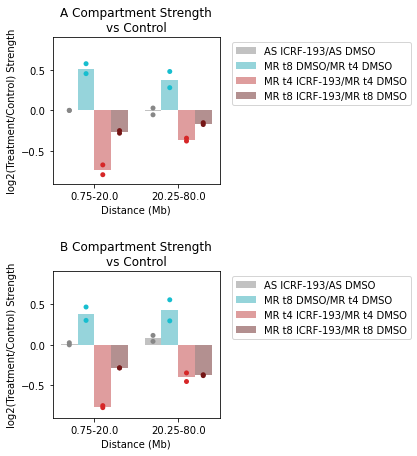

In [83]:
#https://stackoverflow.com/questions/64223870/seaborn-overlap-swarmplot-on-barplot
cmap_bar = sns.color_palette(['#878787','#17BECF', '#D62728','#751616'])
gs = GridSpec(nrows= 2, ncols=1, wspace = 0.6, hspace = 0.6)

plt.figure(figsize=(3, 7))

for i, comp in enumerate(['A', 'B']):
    ax = plt.subplot(gs[i])

    sns.stripplot(x='Distance_Mb', 
                  y='Score', 
                  hue='Label', 
                  dodge=True, 
                  data=comp_score_df.loc[comp_score_df['Compartment'] == comp, :], 
                  jitter = False, 
                  palette = cmap_bar, 
                  ax = ax)
    ax1 = sns.barplot(x='Distance_Mb', 
                      y='Score', 
                      hue='Label', 
                      data=comp_score_df.loc[comp_score_df['Compartment'] == comp, :], 
                      palette = cmap_bar, 
                      alpha = 0.5, 
                      ci = False, 
                      ax = ax)
    
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[4:8], labels[4:8], bbox_to_anchor=(1.04,1))
 
    plt.title(f'{comp} Compartment Strength\nvs Control')
    plt.ylabel('log2(Treatment/Control) Strength')  
    plt.ylim(-.9, 0.9)
    plt.xlabel('Distance (Mb)')
        
plt.savefig(f'{outDataDir}/figures/ASandMRICRFG1Sort_R1R2_HiC_CompStrengthByDistance_BarWithScatter_250kbbinEig1.png', dpi = 300, bbox_inches = "tight")

In [84]:
#Plot actual comp strength (not vs control), cis

In [85]:
comp_score_df_cis_2 = pd.DataFrame(columns = ['Condition', 'Compartment', 'Replicate', 'Label', 'Score'])

for cond in conditions[0:12]:
    for comp in ['A', 'B']:
        for band in bands:
            comp_score_df_cis_2 = comp_score_df_cis_2.append({
                'Condition' : cond, 
                'Compartment' : comp, 
                'Replicate' : repdict[cond], 
                'Label' : labeldict[cond],
                'Distance' : band,
                'Distance_Mb' : f'{[(binsize*x)/1e6 for x in band][0]}-{[(binsize*x)/1e6 for x in band][1]}',
                'Score' : strengthABBands_ownE1[cond][band][comp][9]
            }, ignore_index = True)


/tmp/ipykernel_2892575/305325777.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_cis_2 = comp_score_df_cis_2.append({
/tmp/ipykernel_2892575/305325777.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_cis_2 = comp_score_df_cis_2.append({
/tmp/ipykernel_2892575/305325777.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_cis_2 = comp_score_df_cis_2.append({
/tmp/ipykernel_2892575/305325777.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_cis_2 = comp_score_df_cis_2.append({
/tmp/ipykernel_2892575/305325777.py:6: FutureWarning: The frame.append method is deprecated and will

In [86]:
comp_score_df_cis_2

Condition Compartment Replicate           Label     Score   Distance  \
0     AS_DMSO_R1           A        R1         AS DMSO   4.29873    (3, 80)   
1     AS_DMSO_R1           A        R1         AS DMSO    6.2894  (81, 320)   
2     AS_DMSO_R1           B        R1         AS DMSO   6.90765    (3, 80)   
3     AS_DMSO_R1           B        R1         AS DMSO  5.490063  (81, 320)   
4     AS_ICRF_R1           A        R1     AS ICRF-193  4.304352    (3, 80)   
5     AS_ICRF_R1           A        R1     AS ICRF-193  6.420678  (81, 320)   
6     AS_ICRF_R1           B        R1     AS ICRF-193   6.89385    (3, 80)   
7     AS_ICRF_R1           B        R1     AS ICRF-193  5.938761  (81, 320)   
8   MR_t4DMSO_R1           A        R1      MR t4 DMSO  2.712191    (3, 80)   
9   MR_t4DMSO_R1           A        R1      MR t4 DMSO  3.840562  (81, 320)   
10  MR_t4DMSO_R1           B        R1      MR t4 DMSO  4.120506    (3, 80)   
11  MR_t4DMSO_R1           B        R1      MR t4 DMSO  3.459832  (81, 320)   
12  MR_t4ICRF_R1           A        R1  MR t4 ICRF-193  1.705193    (3, 80)   
13  MR_t4ICRF_R1           A        R1  MR t4 ICRF-193  3.032238  (81, 320)   
14  MR_t4ICRF_R1           B        R1  MR t4 ICRF-193  2.408259    (3, 80)   
15  MR_t4ICRF_R1           B        R1  MR t4 ICRF-193  2.718621  (81, 320)   
16  MR_t8DMSO_R1           A        R1      MR t8 DMSO  4.040386    (3, 80)   
17  MR_t8DMSO_R1           A        R1      MR t8 DMSO  5.354051  (81, 320)   
18  MR_t8DMSO_R1           B        R1      MR t8 DMSO  5.678149    (3, 80)   
19  MR_t8DMSO_R1           B        R1      MR t8 DMSO  5.070602  (81, 320)   
20  MR_t8ICRF_R1           A        R1  MR t8 ICRF-193   3.40284    (3, 80)   
21  MR_t8ICRF_R1           A        R1  MR t8 ICRF-193  4.824085  (81, 320)   
22  MR_t8ICRF_R1           B        R1  MR t8 ICRF-193  4.653335    (3, 80)   
23  MR_t8ICRF_R1           B        R1  MR t8 ICRF-193  3.893049  (81, 320)   
24    AS_DMSO_R2           A        R2         AS DMSO  4.962793    (3, 80)   
25    AS_DMSO_R2           A        R2         AS DMSO  6.980116  (81, 320)   
26    AS_DMSO_R2           B        R2         AS DMSO  7.737157    (3, 80)   
27    AS_DMSO_R2           B        R2         AS DMSO  5.983307  (81, 320)   
28    AS_ICRF_R2           A        R2     AS ICRF-193  4.961053    (3, 80)   
29    AS_ICRF_R2           A        R2     AS ICRF-193  6.725487  (81, 320)   
30    AS_ICRF_R2           B        R2     AS ICRF-193  7.862952    (3, 80)   
31    AS_ICRF_R2           B        R2     AS ICRF-193  6.151519  (81, 320)   
32  MR_t4DMSO_R2           A        R2      MR t4 DMSO  3.052224    (3, 80)   
33  MR_t4DMSO_R2           A        R2      MR t4 DMSO  4.350804  (81, 320)   
34  MR_t4DMSO_R2           B        R2      MR t4 DMSO  4.710607    (3, 80)   
35  MR_t4DMSO_R2           B        R2      MR t4 DMSO  3.944092  (81, 320)   
36  MR_t4ICRF_R2           A        R2  MR t4 ICRF-193  1.765177    (3, 80)   
37  MR_t4ICRF_R2           A        R2  MR t4 ICRF-193  3.352348  (81, 320)   
38  MR_t4ICRF_R2           B        R2  MR t4 ICRF-193  2.800438    (3, 80)   
39  MR_t4ICRF_R2           B        R2  MR t4 ICRF-193   2.87986  (81, 320)   
40  MR_t8DMSO_R2           A        R2      MR t8 DMSO  4.177807    (3, 80)   
41  MR_t8DMSO_R2           A        R2      MR t8 DMSO  5.283239  (81, 320)   
42  MR_t8DMSO_R2           B        R2      MR t8 DMSO  5.791204    (3, 80)   
43  MR_t8DMSO_R2           B        R2      MR t8 DMSO  4.829275  (81, 320)   
44  MR_t8ICRF_R2           A        R2  MR t8 ICRF-193  3.441071    (3, 80)   
45  MR_t8ICRF_R2           A        R2  MR t8 ICRF-193  4.685828  (81, 320)   
46  MR_t8ICRF_R2           B        R2  MR t8 ICRF-193  4.750998    (3, 80)   
47  MR_t8ICRF_R2           B        R2  MR t8 ICRF-193  3.735767  (81, 320)   

   Distance_Mb  
0    0.75-20.0  
1   20.25-80.0  
2    0.75-20.0  
3   20.25-80.0  
4    0.75-20.0  
5   20.25-80.0  
6    0.75-20.0  

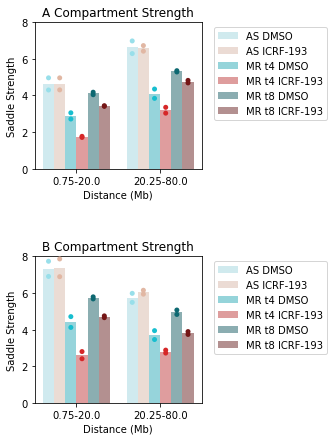

In [87]:
#https://stackoverflow.com/questions/64223870/seaborn-overlap-swarmplot-on-barplot
cmap_bar = sns.color_palette(['#98DFEA', '#E1B7A3', '#17BECF', '#D62728','#0D6871', '#751616'])
gs = GridSpec(nrows= 2, ncols=1, wspace = 0.6, hspace = 0.6)

plt.figure(figsize=(3, 7))

for i, comp in enumerate(['A', 'B']):
    ax = plt.subplot(gs[i])

    sns.stripplot(x='Distance_Mb', 
                  y='Score', 
                  hue='Label', 
                  dodge=True, 
                  data=comp_score_df_cis_2.loc[comp_score_df_cis_2['Compartment'] == comp, :], 
                  jitter = False, 
                  palette = cmap_bar, 
                  ax = ax)
    ax1 = sns.barplot(x='Distance_Mb', 
                      y='Score', 
                      hue='Label', 
                      data=comp_score_df_cis_2.loc[comp_score_df_cis_2['Compartment'] == comp, :], 
                      palette = cmap_bar, 
                      alpha = 0.5, 
                      ci = False, 
                      ax = ax)
    
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[6:12], labels[6:12], bbox_to_anchor=(1.04,1))
 
    plt.title(f'{comp} Compartment Strength')
    plt.ylabel('Saddle Strength')  
    plt.ylim(0, 8)
    plt.xlabel('Distance (Mb)')
        
plt.savefig(f'{outDataDir}/figures/ASandMRICRFG1Sort_R1R2_HiC_compstrength_notvsctrl_Eig1.png', dpi = 300, bbox_inches = "tight")

In [ ]:
#Inter-chromosomal compartment strength

In [88]:
# create pairwise combinations of chromosomes for calculating average interactions:
regions = bioframe.core.construction.add_ucsc_name_column(bioframe.from_any(hg38_chromsizes))
region_pairs = list(combinations(regions[['chrom', 'start', 'end']].values, 2))

In [89]:
region_pairs

[(array(['chr4', 0, 190214555], dtype=object),
  array(['chr14', 0, 107043718], dtype=object)),
 (array(['chr4', 0, 190214555], dtype=object),
  array(['chr17', 0, 83257441], dtype=object)),
 (array(['chr4', 0, 190214555], dtype=object),
  array(['chr18', 0, 80373285], dtype=object)),
 (array(['chr4', 0, 190214555], dtype=object),
  array(['chr20', 0, 64444167], dtype=object)),
 (array(['chr4', 0, 190214555], dtype=object),
  array(['chr21', 0, 46709983], dtype=object)),
 (array(['chr14', 0, 107043718], dtype=object),
  array(['chr17', 0, 83257441], dtype=object)),
 (array(['chr14', 0, 107043718], dtype=object),
  array(['chr18', 0, 80373285], dtype=object)),
 (array(['chr14', 0, 107043718], dtype=object),
  array(['chr20', 0, 64444167], dtype=object)),
 (array(['chr14', 0, 107043718], dtype=object),
  array(['chr21', 0, 46709983], dtype=object)),
 (array(['chr17', 0, 83257441], dtype=object),
  array(['chr18', 0, 80373285], dtype=object)),
 (array(['chr17', 0, 83257441], dtype=object)

In [90]:
regions.to_csv(f'{outDataDir}/data/hg38_chroms.bed', index = False, sep = '\t', header = None)

In [91]:
for cond in conditions:
    in_fname = clr_paths_250kb[cond]
    region_fname = f'{outDataDir}/data/hg38_chroms.bed'
    out_fname = f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.trans.cli.tsv'
    !bsub -q short -W 01:00 -e /lsf_jobs/LSB_%J.err -o /lsf_jobs/LSB_%J.log \
        -n 4 -R span[hosts=1] -R select[ib] -R rusage[mem=4000] -R select[rh=8] \
        "cooltools expected-trans -p 4 -o $out_fname $in_fname --view $region_fname"


Job <8234583> is submitted to queue <short>.
Job <8234587> is submitted to queue <short>.
Job <8234590> is submitted to queue <short>.
Job <8234593> is submitted to queue <short>.
Job <8234596> is submitted to queue <short>.
Job <8234599> is submitted to queue <short>.
Job <8234602> is submitted to queue <short>.
Job <8234605> is submitted to queue <short>.
Job <8234608> is submitted to queue <short>.
Job <8234610> is submitted to queue <short>.
Job <8234613> is submitted to queue <short>.
Job <8234616> is submitted to queue <short>.
Job <8234619> is submitted to queue <short>.
Job <8234622> is submitted to queue <short>.
Job <8234625> is submitted to queue <short>.
Job <8234628> is submitted to queue <short>.
Job <8234630> is submitted to queue <short>.
Job <8234633> is submitted to queue <short>.


In [92]:
#Saddle strength - AA, BB, AA + BB

In [93]:
# use this if expected already run, will be much faster
trans_exp = {}

for cond in conditions:
    trans_exp[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.trans.cli.tsv', sep='\t')

In [94]:
trans_exp[cond]

region1            region2  n_valid  count.sum  balanced.sum  \
0    chr4:0-190214555  chr14:0-107043718   260703    17865.0      7.234780   
1    chr4:0-190214555   chr17:0-83257441   230076    20980.0      7.750067   
2    chr4:0-190214555   chr18:0-80373285   220365    13807.0      5.892180   
3    chr4:0-190214555   chr20:0-64444167   177786    16027.0      5.268689   
4    chr4:0-190214555   chr21:0-46709983    97857     6993.0      2.999254   
5   chr14:0-107043718   chr17:0-83257441   107492    23167.0      6.030951   
6   chr14:0-107043718   chr18:0-80373285   102955    14702.0      4.431804   
7   chr14:0-107043718   chr20:0-64444167    83062    17942.0      4.188970   
8   chr14:0-107043718   chr21:0-46709983    45719     7628.0      2.337284   
9    chr17:0-83257441   chr18:0-80373285    90860    19364.0      5.338090   
10   chr17:0-83257441   chr20:0-64444167    73304    27901.0      5.816714   
11   chr17:0-83257441   chr21:0-46709983    40348    10699.0      2.926847   
12   chr18:0-80373285   chr20:0-64444167    70210    16534.0      4.047280   
13   chr18:0-80373285   chr21:0-46709983    38645     7176.0      2.275692   
14   chr20:0-64444167   chr21:0-46709983    31178     9353.0      2.285927   

    count.avg  balanced.avg  
0    0.068526      0.000028  
1    0.091187      0.000034  
2    0.062655      0.000027  
3    0.090148      0.000030  
4    0.071461      0.000031  
5    0.215523      0.000056  
6    0.142800      0.000043  
7    0.216007      0.000050  
8    0.166845      0.000051  
9    0.213119      0.000059  
10   0.380620      0.000079  
11   0.265168      0.000073  
12   0.235494      0.000058  
13   0.185690      0.000059  
14   0.299987      0.000073

In [95]:
regions

chrom  start        end               name
0   chr4      0  190214555   chr4:0-190214555
1  chr14      0  107043718  chr14:0-107043718
2  chr17      0   83257441   chr17:0-83257441
3  chr18      0   80373285   chr18:0-80373285
4  chr20      0   64444167   chr20:0-64444167
5  chr21      0   46709983   chr21:0-46709983

In [96]:
#Use the function to return saddledata for each band size (just good chromosomes, by arm)

trans_sums = {}
trans_counts = {}

for cond in conditions:
    trans_sums[cond], trans_counts[cond] = cooltools.api.saddle.saddle(
        clr = clrs250kb[cond], 
        expected = trans_exp[cond], 
        contact_type = 'trans',
        view_df = regions,
        track = eigs[cond][['chrom', 'start', 'end', 'E1']],
        qrange = (0.02, 0.98),
        n_bins = 50,
        verbose = False
        )

/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/lib/common.py:300: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


In [97]:
#Compartment strength - AA vs BB, in trans

In [98]:
#AA vs BB compartment scores
def saddle_strengthAB(S, C):
    """
    Parameters
    ----------
    S, C : 2D arrays, square, same shape
        Saddle sums and counts, respectively
        
    Returns
    -------
    2x1D array
    Ratios of cumulative corner interaction scores, where the saddle data is 
    separately AA/AB and BB/BA corners with increasing extent
    
    """
    m, n = S.shape
    if m != n:
        raise ValueError("`saddledata` should be square.")

    ratiosA = np.zeros(n)
    for k in range(1, n):
        intra_sumA = S[n-k:n, n-k:n].sum() 
        intra_countA = C[n-k:n, n-k:n].sum()
        intraA = intra_sumA / intra_countA
        
        inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
        inter_count =  C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
        inter = inter_sum / inter_count
        
        ratiosA[k] = intraA / inter
        
    ratiosB = np.zeros(n)
    for k in range(1, n):
        intra_sumB = S[0:k, 0:k].sum()
        intra_countB = C[0:k, 0:k].sum()
        intraB = intra_sumB / intra_countB
        
        inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
        inter_count =  C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
        inter = inter_sum / inter_count
        
        ratiosB[k] = intraB / inter
    
    ratios = {
        'A' : ratiosA,
        'B' : ratiosB
    }
    
    return ratios

In [99]:
#Own Eig1

In [100]:
#AA vs BB strength, trans
strengthABTrans_ownE1 = {}
for cond in conditions:
    strengthABTrans_ownE1[cond] = saddle_strengthAB(trans_sums[cond], trans_counts[cond])

In [101]:
#log2 ratio of treatment/control saddle strength within each replicate
sep_log2_treatvsctrl_trans = {}
for comp in ['A', 'B']:
    sep_log2_treatvsctrl_trans[comp] = {}
    for treat, ctrl in zip(SepTreatConds, SepCtrlConds):
        sep_log2_treatvsctrl_trans[comp][f'{treat}vs{ctrl}'] = np.log2(strengthABTrans_ownE1[treat][comp]) - np.log2(strengthABTrans_ownE1[ctrl][comp])
        

/tmp/ipykernel_2892575/894272999.py:6: RuntimeWarning: divide by zero encountered in log2
  sep_log2_treatvsctrl_trans[comp][f'{treat}vs{ctrl}'] = np.log2(strengthABTrans_ownE1[treat][comp]) - np.log2(strengthABTrans_ownE1[ctrl][comp])
/tmp/ipykernel_2892575/894272999.py:6: RuntimeWarning: invalid value encountered in subtract
  sep_log2_treatvsctrl_trans[comp][f'{treat}vs{ctrl}'] = np.log2(strengthABTrans_ownE1[treat][comp]) - np.log2(strengthABTrans_ownE1[ctrl][comp])


In [102]:
#Plot bargraph of avg and dots of replicates log2(treat/ctrl) for AA and BB comp strength, trans
#5 bin square - top 10% A or B

trans_comp_score_df = pd.DataFrame(columns = ['Comparison', 'Compartment', 'Replicate', 'Label', 'Score'])

for treat, ctrl in zip(SepTreatConds, SepCtrlConds):
    for comp in ['A', 'B']:
        trans_comp_score_df = trans_comp_score_df.append({
            'Comparison' : f'{treat}vs{ctrl}', 
            'Compartment' : comp, 
            'Replicate' : repdict[treat], 
            'Label' : f'{labeldict[treat]}/{labeldict[ctrl]}',
            'Score' : sep_log2_treatvsctrl_trans[comp][f'{treat}vs{ctrl}'][4]
        }, ignore_index = True)
    

/tmp/ipykernel_2892575/2095572768.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trans_comp_score_df = trans_comp_score_df.append({
/tmp/ipykernel_2892575/2095572768.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trans_comp_score_df = trans_comp_score_df.append({
/tmp/ipykernel_2892575/2095572768.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trans_comp_score_df = trans_comp_score_df.append({
/tmp/ipykernel_2892575/2095572768.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trans_comp_score_df = trans_comp_score_df.append({
/tmp/ipykernel_2892575/2095572768.py:8: FutureWarning: The frame.append method is deprecated and

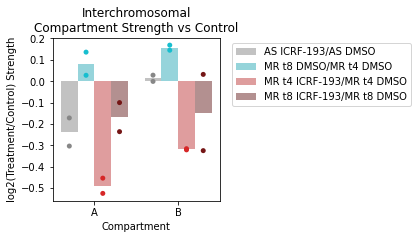

In [103]:
#https://stackoverflow.com/questions/64223870/seaborn-overlap-swarmplot-on-barplot

cmap_bar = sns.color_palette(['#878787', '#17BECF', '#D62728', '#751616'])
gs = GridSpec(nrows= 1, ncols=2, wspace = 0.6, hspace = 0.3)

plt.figure(figsize=(3, 3))

sns.stripplot(x='Compartment', y='Score', hue='Label', dodge=True, data=trans_comp_score_df, jitter = False, palette = cmap_bar)
ax1 = sns.barplot(x='Compartment', y='Score', hue='Label', data=trans_comp_score_df, palette = cmap_bar, alpha = 0.5, ci = False)
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[4:8], labels[4:8], bbox_to_anchor=(1.04,1), loc="upper left")
 
plt.title(f'Interchromosomal\nCompartment Strength vs Control')
plt.ylabel('log2(Treatment/Control) Strength')  
plt.xlabel('Compartment')
        
plt.savefig(f'{outDataDir}/figures/ASandMRICRFG1Sort_HiC_TransCompStrength_BarWithScatter_250kbbinEig1.png', dpi = 300, bbox_inches = "tight")

In [104]:
conditions

['AS_DMSO_R1',
 'AS_ICRF_R1',
 'MR_t4DMSO_R1',
 'MR_t4ICRF_R1',
 'MR_t8DMSO_R1',
 'MR_t8ICRF_R1',
 'AS_DMSO_R2',
 'AS_ICRF_R2',
 'MR_t4DMSO_R2',
 'MR_t4ICRF_R2',
 'MR_t8DMSO_R2',
 'MR_t8ICRF_R2',
 'AS_DMSO_R1R2',
 'AS_ICRF_R1R2',
 'MR_t4DMSO_R1R2',
 'MR_t4ICRF_R1R2',
 'MR_t8DMSO_R1R2',
 'MR_t8ICRF_R1R2']

In [105]:
#Plot bargraph of avg and dots of replicates - not vs control for AA and BB comp strength, trans
#5 bin square - top 10% A or B

comp_score_df_trans_2 = pd.DataFrame(columns = ['Condition', 'Compartment', 'Replicate', 'Label', 'Score'])

for cond in conditions[0:12]:
    for comp in ['A', 'B']:
        comp_score_df_trans_2 = comp_score_df_trans_2.append({
            'Condition' : cond, 
            'Compartment' : comp, 
            'Replicate' : repdict[cond], 
            'Label' : labeldict[cond],
            'Score' : strengthABTrans_ownE1[cond][comp][4]
        }, ignore_index = True)


/tmp/ipykernel_2892575/3325438838.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_trans_2 = comp_score_df_trans_2.append({
/tmp/ipykernel_2892575/3325438838.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_trans_2 = comp_score_df_trans_2.append({
/tmp/ipykernel_2892575/3325438838.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_trans_2 = comp_score_df_trans_2.append({
/tmp/ipykernel_2892575/3325438838.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp_score_df_trans_2 = comp_score_df_trans_2.append({
/tmp/ipykernel_2892575/3325438838.py:8: FutureWarning: The frame.append method i

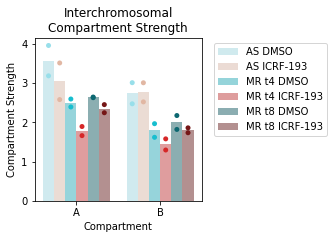

In [106]:
#https://stackoverflow.com/questions/64223870/seaborn-overlap-swarmplot-on-barplot
cmap_bar = sns.color_palette(['#98DFEA', '#E1B7A3', '#17BECF', '#D62728','#0D6871', '#751616'])
gs = GridSpec(nrows= 1, ncols=2, wspace = 0.6, hspace = 0.3)

plt.figure(figsize=(3, 3))

sns.stripplot(x='Compartment', y='Score', hue='Label', dodge=True, data=comp_score_df_trans_2, jitter = False, palette = cmap_bar)
ax1 = sns.barplot(x='Compartment', y='Score', hue='Label', data=comp_score_df_trans_2, palette = cmap_bar, alpha = 0.5, ci = False)
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[6:12], labels[6:12], bbox_to_anchor=(1.04,1), loc="upper left")
 
plt.title(f'Interchromosomal\nCompartment Strength')
plt.ylabel('Compartment Strength')  
plt.xlabel('Compartment')
        
plt.savefig(f'{outDataDir}/figures/ASandMRICRFG1Sort_HiC_TransCompStrength_AllSamples_BarWithScatter_250kbbinEig1.png', dpi = 300, bbox_inches = "tight")

In [ ]:
#Density and scaling plots
#https://cooltools.readthedocs.io/en/latest/notebooks/contacts_vs_distance.html

In [107]:
#Calculate expected on 1kb binned coolers

In [108]:
scaling_conditions = [
    'AS_DMSO_R1',
    'AS_ICRF_R1',
    'MR_t4DMSO_R1',
    'MR_t4ICRF_R1',
    'MR_t8DMSO_R1',
    'MR_t8ICRF_R1',
    'AS_DMSO_R2',
    'AS_ICRF_R2',
    'MR_t4DMSO_R2',
    'MR_t4ICRF_R2',
    'MR_t8DMSO_R2',
    'MR_t8ICRF_R2',
    'AS_DMSO_R1R2',
    'AS_ICRF_R1R2',
    'MR_t4DMSO_R1R2',
    'MR_t4ICRF_R1R2',
    'MR_t8DMSO_R1R2',
    'MR_t8ICRF_R1R2',
]

In [109]:
#coolers - 1kb bins
binsize = 1000

clr_paths_1kb = {}
for cond in scaling_conditions:
    clr_paths_1kb[cond] = f'{outDataDir}/data/{long_names[cond]}.sampled.hg38.mapq_30.1000.mcool::resolutions/{binsize}'


In [110]:
for cond in scaling_conditions:
    in_fname = clr_paths_1kb[cond]
    region_fname = f'{outDataDir}/data/hg38_arms_filtered.bed'
    out_fname = f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.tsv'
    !bsub -q short -W 01:00 -e /lsf_jobs/LSB_%J.err -o /lsf_jobs/LSB_%J.log \
        -n 8 -R span[hosts=1] -R select[ib] -R rusage[mem=2000] -R select[rh=8] \
        "cooltools expected-cis -p 8 -o $out_fname --ignore-diags 2 --view $region_fname $in_fname"

Job <8237949> is submitted to queue <short>.
Job <8237950> is submitted to queue <short>.
Job <8237951> is submitted to queue <short>.
Job <8237952> is submitted to queue <short>.
Job <8237953> is submitted to queue <short>.
Job <8237954> is submitted to queue <short>.
Job <8237955> is submitted to queue <short>.
Job <8237956> is submitted to queue <short>.
Job <8237957> is submitted to queue <short>.
Job <8237958> is submitted to queue <short>.
Job <8237959> is submitted to queue <short>.
Job <8237960> is submitted to queue <short>.
Job <8237962> is submitted to queue <short>.
Job <8237963> is submitted to queue <short>.
Job <8237964> is submitted to queue <short>.
Job <8237965> is submitted to queue <short>.
Job <8237966> is submitted to queue <short>.
Job <8237967> is submitted to queue <short>.


In [111]:
#read in log binned expected for plotting
exp = {}
for cond in scaling_conditions:
    exp[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.tsv', sep = '\t')
 

In [112]:
log_exp = {}
for cond in scaling_conditions:
    log_exp[cond] = cooltools.api.expected.logbin_expected(
        exp[cond], summary_name='balanced.sum', bins_per_order_magnitude=10, 
        bin_layout='fixed', min_nvalid=200, min_count=50)

In [113]:
log_exp_agg = {}
for cond in scaling_conditions:
    log_exp_agg[cond] = cooltools.api.expected.combine_binned_expected(
        log_exp[cond][0], binned_exp_slope=log_exp[cond][1],
        Pc_name='balanced.avg', minmax_drop_bins=2, concat_original=False)

In [114]:
#Add Density column - (balanced.avg * n_valid)/sum(balanced.avg * n_valid)
for cond in scaling_conditions:
    log_exp_agg[cond][0]['density'] = (
        log_exp_agg[cond][0]['balanced.avg'] * log_exp_agg[cond][0]['n_valid'])/np.nansum(
        log_exp_agg[cond][0]['balanced.avg'] * log_exp_agg[cond][0]['n_valid'])

In [115]:
log_exp_agg[cond][0].head()

dist_bin_id  balanced.avg  n_valid  dist.avg  dist_bin_start  dist_bin_end  \
0            1      0.005045   280770  2.000000             2.0           2.0   
1            2      0.004705   278947  3.000000             3.0           3.0   
2            3      0.004327   277594  4.000000             4.0           4.0   
3            4      0.004071   277001  5.000000             5.0           5.0   
4            5      0.003595   552837  6.499914             6.0           7.0   

    low_err  high_err   density  
0  0.004382  0.005809  0.011230  
1  0.004089  0.005413  0.010405  
2  0.003783  0.004949  0.009522  
3  0.003535  0.004688  0.008940  
4  0.003163  0.004085  0.015755

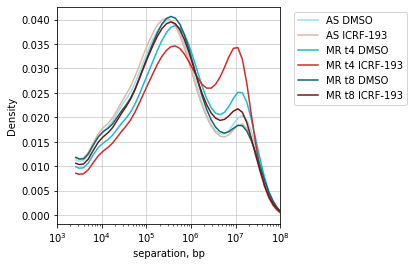

In [116]:
#Smooth density before plotting, on log bins like for scaling. Then convert back to linear so can use semilogx
from cooltools.lib import numutils
smoothf = der_smooth_function_combined=lambda x: numutils.robust_gauss_filter(x, 1.3)

f, ax = plt.subplots(
    figsize=(4, 4))

for cond in ComboConds:
    ax.semilogx(
        10**smoothf(np.log10(log_exp_agg[cond][0]['dist.avg']*1000)),
        smoothf(log_exp_agg[cond][0]['density']),
        color = sampleColors[cond],
        label = samplePlotNames[cond],
        ls = sampleLineStyles[cond]
    )

    ax.set(
        xlabel='separation, bp',
        ylabel='Density',
        xlim=(1e3,1e8),
        #ylim=(0, 0.07)
    )

    ax.grid(lw=0.5)
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    #ax.set_aspect(100)
    
plt.savefig(f'{outDataDir}/figures/ASandMRICRFG1Sort_R1R2_Density.png', dpi = 300, bbox_inches = "tight")

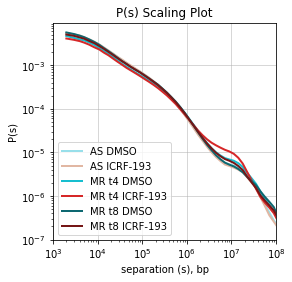

In [117]:
#Plot scaling - combo 

f, ax = plt.subplots(
    figsize=(4, 4))

for cond in ComboConds:
    ax.loglog(
        log_exp_agg[cond][0]['dist.avg']*1000,
        log_exp_agg[cond][0]['balanced.avg'],
        color = sampleColors[cond],
        label = samplePlotNames[cond],
        ls = sampleLineStyles[cond],
        lw = 2
    )

ax.set(
    xlabel='separation (s), bp',
    ylabel='P(s)',
    xlim=(1e3,1e8))

ax.grid(lw=0.5)
ax.legend()
plt.title('P(s) Scaling Plot')
    
plt.savefig(f'{outDataDir}/figures/ASandMRICRFG1Sort_R1R2_Scaling_Combo.png', dpi = 300, bbox_inches = "tight")

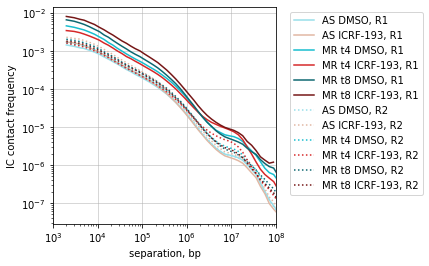

In [118]:
#Plot scaling and slope separately

f, ax = plt.subplots(
    figsize=(4, 4))

for cond in SepConds:
    ax.loglog(
        log_exp_agg[cond][0]['dist.avg']*1000,
        log_exp_agg[cond][0]['balanced.avg'],
        color = sampleColors[cond],
        label = samplePlotNames[cond],
        linestyle = sampleLineStyles[cond]
    )

    ax.set(
        xlabel='separation, bp',
        ylabel='IC contact frequency',
        xlim=(1e3,1e8)
    )
    #ax.set_aspect(1.0)
    ax.grid(lw=0.5)
    ax.legend(bbox_to_anchor=(1.04,1))
    
plt.savefig(f'{outDataDir}/figures/ASandMRICRFG1Sort_R1R2_Scaling_Separate.png', dpi = 300, bbox_inches = "tight")

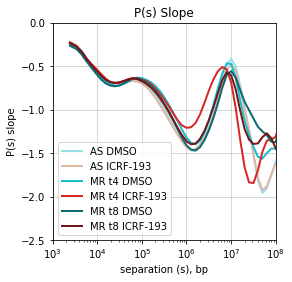

In [119]:
#Plot slope - combo

f, ax = plt.subplots(
    figsize=(4, 4))

for cond in ComboConds:
    ax.semilogx(
        log_exp_agg[cond][1]['dist.avg']*1000,
        log_exp_agg[cond][1]['slope'],
        color = sampleColors[cond],
        label = samplePlotNames[cond],
        ls = sampleLineStyles[cond],
        lw = 2
    )

ax.set(
    xlabel='separation (s), bp',
    ylabel='P(s) slope',
    ylim=(-2.5, 0),
    xlim=(1e3,1e8)
    )

ax.grid(lw=0.5)
plt.legend()
plt.title('P(s) Slope')
    
plt.savefig(f'{outDataDir}/figures/ASandMRICRFG1Sort_R1R2_ScalingSlope_Combo.png', dpi = 300, bbox_inches = "tight")

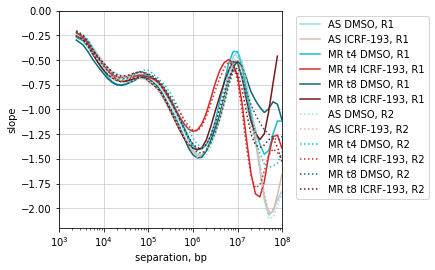

In [120]:
#Plot scaling and slope separately

f, ax = plt.subplots(
    figsize=(4, 4))

for cond in SepConds:
    ax.semilogx(
        log_exp_agg[cond][1]['dist.avg']*1000,
        log_exp_agg[cond][1]['slope'],
        color = sampleColors[cond],
        label = samplePlotNames[cond],
        linestyle = sampleLineStyles[cond]
    )

    ax.set(
        xlabel='separation, bp',
        ylabel='slope',
        ylim=(-2.2, 0),
        xlim=(1e3,1e8)
    )

    ax.grid(lw=0.5)
    #ax.set_aspect(1)
    plt.legend(bbox_to_anchor=(1.04,1))
    
plt.savefig(f'{outDataDir}/figures/ASandMRICRFG1Sort_R1R2_ScalingSlope_Separate.png', dpi = 300, bbox_inches = "tight")

In [121]:
#Call insulation, pileup at control boundaries

In [122]:
#coolers - 10kb bins
binsize = 10000

clr_paths_10kb = {}
for cond in conditions:
    clr_paths_10kb[cond] = f'{outDataDir}/data/{long_names[cond]}.sampled.hg38.mapq_30.1000.mcool::resolutions/{binsize}'
    
clrs10kb = {
    cond: cooler.Cooler(clr_paths_10kb[cond]) for cond in conditions
}

In [123]:
good_chroms = ['chr4', 'chr14', 'chr17', 'chr18', 'chr20', 'chr21']

In [124]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
# create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)

In [125]:
# Select only chromosomes that are present in the good chromosomes
hg38_chromsizes = hg38_chromsizes.loc[good_chroms]
hg38_arms = hg38_arms[hg38_arms.chrom.isin(good_chroms)].reset_index(drop=True)
hg38_chrom_vf = bioframe.make_viewframe(hg38_chromsizes)

In [126]:
#call insulation
insulation_table = {}

for cond in conditions:
    insulation_table[cond] = insulation(clrs10kb[cond], 250000, verbose=False, ignore_diags = 2, view_df=hg38_chrom_vf)

In [127]:
insulation_table[cond]

chrom     start       end region  is_bad_bin  \
68946    chr4         0     10000   chr4        True   
68947    chr4     10000     20000   chr4        True   
68948    chr4     20000     30000   chr4        True   
68949    chr4     30000     40000   chr4        True   
68950    chr4     40000     50000   chr4        True   
...       ...       ...       ...    ...         ...   
282422  chr21  46660000  46670000  chr21       False   
282423  chr21  46670000  46680000  chr21       False   
282424  chr21  46680000  46690000  chr21        True   
282425  chr21  46690000  46700000  chr21        True   
282426  chr21  46700000  46709983  chr21        True   

        log2_insulation_score_250000  n_valid_pixels_250000  \
68946                            NaN                    0.0   
68947                            NaN                    0.0   
68948                            NaN                    0.0   
68949                            NaN                    0.0   
68950                            NaN                    0.0   
...                              ...                    ...   
282422                      1.323274                   47.0   
282423                      1.250135                   23.0   
282424                           NaN                    0.0   
282425                           NaN                    0.0   
282426                           NaN                    0.0   

        boundary_strength_250000  is_boundary_250000  
68946                        NaN               False  
68947                        NaN               False  
68948                        NaN               False  
68949                        NaN               False  
68950                        NaN               False  
...                          ...                 ...  
282422                       NaN               False  
282423                       NaN               False  
282424                       NaN               False  
282425                       NaN               False  
282426                       NaN               False  

[57207 rows x 9 columns]

In [128]:
# Functions to help with plotting
def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), *args, **kwargs)
    im.set_rasterized(True)
    return im

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

/tmp/ipykernel_2892575/1043245041.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


(35000000.0, 40000000.0)

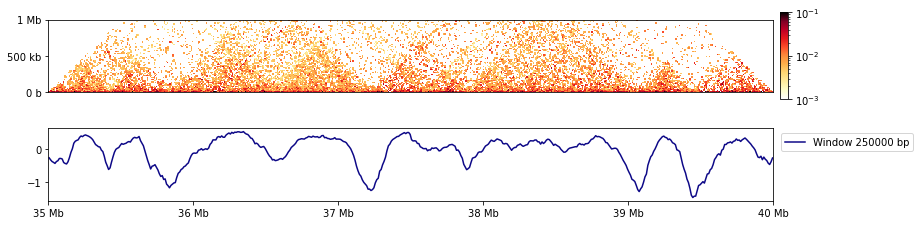

In [129]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid import make_axes_locatable
import bioframe

region = ('chr14', 35000000, 40000000)
norm = LogNorm(vmax=0.1, vmin=0.001)
data = clrs10kb['MR_t8DMSO_R1R2'].matrix(balance=True).fetch(region)
f, ax = plt.subplots(figsize=(20, 4))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=10000, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 1000000)
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table['MR_t8DMSO_R1R2'], region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)
ins_ax.set_prop_cycle(plt.cycler("color", plt.cm.plasma(np.linspace(0,1,5))))
ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), insul_region['log2_insulation_score_250000'], label='Window 250000 bp')

ins_ax.legend(bbox_to_anchor=(1.2,1), loc="upper right")

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

(35000000.0, 40000000.0)

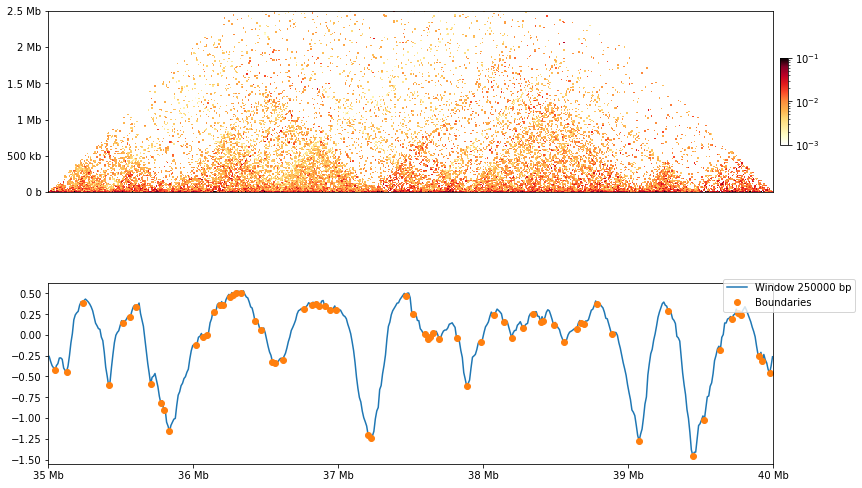

In [130]:
f, ax = plt.subplots(figsize=(20, 10))
im = pcolormesh_45deg(ax, data, start=region[1], resolution=10000, norm=norm, cmap='fall')
ax.set_aspect(0.5)
ax.set_ylim(0, 2500000)
format_ticks(ax, rotate=False)
ax.xaxis.set_visible(False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.1, aspect=6)
plt.colorbar(im, cax=cax)

insul_region = bioframe.select(insulation_table['MR_t8DMSO_R1R2'], region)

ins_ax = divider.append_axes("bottom", size="50%", pad=0., sharex=ax)

ins_ax.plot(insul_region[['start', 'end']].mean(axis=1), insul_region['log2_insulation_score_250000'], label='Window 250000 bp')
boundaries = insul_region[~np.isnan(insul_region['boundary_strength_250000'])]
ins_ax.plot(boundaries[['start', 'end']].mean(axis=1), boundaries['log2_insulation_score_250000'], 'o', label='Boundaries')

ins_ax.legend(bbox_to_anchor=(1.12, 1.05), loc='upper right')

format_ticks(ins_ax, y=False, rotate=False)
ax.set_xlim(region[1], region[2])

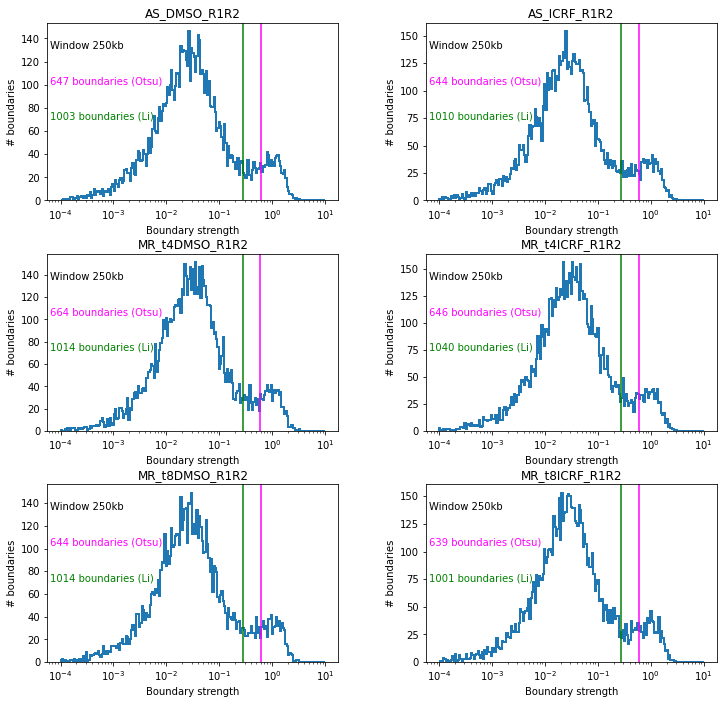

In [131]:
from skimage.filters import threshold_li, threshold_otsu
windows = [250000]
histkwargs = dict(
    bins=10**np.linspace(-4,1,200),
    histtype='step',
    lw=2,
)

fig = plt.figure(figsize=(12, 16))

gs0 = GridSpec(nrows = 4, ncols = 2, wspace=0.3, hspace = 0.3)

thresholds_li = {}
thresholds_otsu = {}
bounds_li = {}
bounds_otsu = {}

for i, cond in enumerate(ComboConds):
    gs1 = GridSpecFromSubplotSpec(nrows=len(windows), ncols=1, wspace = 0.3, hspace = 1, subplot_spec = gs0[i])

    thresholds_li[cond] = {}
    thresholds_otsu[cond] = {}
    bounds_li[cond] = {}
    bounds_otsu[cond] = {}

    for i, w in enumerate(windows):
        ax = plt.subplot(gs1[i])
        ax.hist(
            insulation_table[cond][f'boundary_strength_{w}'],
            **histkwargs
        )
        thresholds_li[cond][w] = threshold_li(insulation_table[cond][f'boundary_strength_{w}'].dropna().values)
        thresholds_otsu[cond][w] = threshold_otsu(insulation_table[cond][f'boundary_strength_{w}'].dropna().values)
        n_boundaries_li = (insulation_table[cond][f'boundary_strength_{w}'].dropna()>=thresholds_li[cond][w]).sum()
        bounds_li[cond][w] = insulation_table[cond][(insulation_table[cond][f'boundary_strength_{w}']>=thresholds_li[cond][w])]
        n_boundaries_otsu = (insulation_table[cond][f'boundary_strength_{w}'].dropna()>=thresholds_otsu[cond][w]).sum()
        bounds_otsu[cond][w] = insulation_table[cond][(insulation_table[cond][f'boundary_strength_{w}']>=thresholds_otsu[cond][w])]

        ax.axvline(thresholds_li[cond][w], c='green')
        ax.axvline(thresholds_otsu[cond][w], c='magenta')
        ax.text(0.01, 0.9,
                 f'Window {w//1000}kb',
                 ha='left',
                 va='top',
                 transform=ax.transAxes)
        ax.text(0.01, 0.7,
                f'{n_boundaries_otsu} boundaries (Otsu)',
                c='magenta',
                ha='left',
                va='top',
                transform=ax.transAxes)
        ax.text(0.01, 0.5,
                f'{n_boundaries_li} boundaries (Li)',
                c='green',
                ha='left',
                va='top',
                transform=ax.transAxes)

        ax.set(
            xscale='log',
            ylabel='# boundaries'
        )

        ax.set(xlabel='Boundary strength')
        plt.title(cond)
    
plt.savefig(f'{outDataDir}/figures/MRandASDMSOvsICRF_AllCond_BoundaryThresholds.png', dpi = 300, 
            bbox_inches = 'tight')

In [132]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')

In [133]:
hg38_chromsizes = hg38_chromsizes.loc[good_chroms]

In [134]:
for cond in conditions:
    for w in windows:
        bioframe.to_bigwig(insulation_table[cond], hg38_chromsizes,
            f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.insul_score_{w}.bw', 
            f'log2_insulation_score_{w}')

In [135]:
import bbi

In [136]:
# Create stackup. flank = .5Mb, nbins = 100, 250kb window, 10kb hi-c resolution
flank = 500000 # Length of flank to one side from the boundary, in basepairs
nbins = 100   # Number of bins to split the region
ins_pileup_signal = {}
for cond in conditions:
    ins_pileup_signal[cond] = bbi.stackup(
        f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.insul_score_250000.bw',
        bounds_otsu['MR_t8DMSO_R1R2'][250000].chrom,
        bounds_otsu['MR_t8DMSO_R1R2'][250000].start-flank,
        bounds_otsu['MR_t8DMSO_R1R2'][250000].end+flank, bins=nbins)

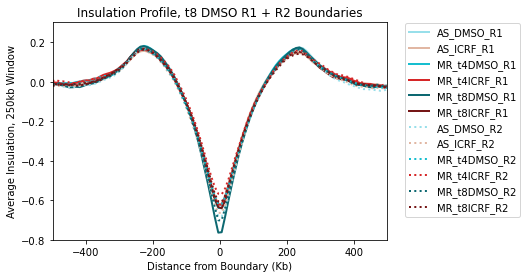

In [137]:
f, ax = plt.subplots(figsize=[6, 4])
flank = 500000
nbins = 100
x = np.linspace(-flank/1e3, flank/1e3, nbins)
for cond in SepConds:
    ax.plot(x, np.nanmean(ins_pileup_signal[cond], axis=0), color = sampleColors[cond], label = cond, 
            ls = sampleLineStyles[cond], lw = 2)
plt.xlim(-flank/1e3, flank/1e3)
plt.ylim(-.8, .3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.1)
plt.title('Insulation Profile, t8 DMSO R1 + R2 Boundaries')
plt.ylabel('Average Insulation, 250kb Window')
plt.xlabel('Distance from Boundary (Kb)')
plt.savefig(f'{outDataDir}/figures/MRandASDMSOvsICRF_InsulationPileup_t8DMSOBoundaries.png', dpi = 300, 
            bbox_inches = 'tight')

In [138]:
#separate out TAD vs Compartment boundaries

In [139]:
#called boundaries from cooler compartments (with gene density)
binsize_comp = 250000

eigs = {}
for cond in conditions:
    eigs[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize_comp//1000}kb.mapq30.byarm.eigs.cis.vecs.txt', sep='\t')

#calling A vs B compartments in each sample
eigsA = {}
for cond in conditions:
    eigsA[cond] = eigs[cond][eigs[cond]['E1'] > 0]
    
eigsB = {}
for cond in conditions:
    eigsB[cond] = eigs[cond][eigs[cond]['E1'] < 0]

compRangesA = {}
for cond in conditions:
    compRangesA[cond] = bioframe.merge(pd.DataFrame(data = {
        'chrom' : eigsA[cond].chrom,
        'start' : eigsA[cond].start,
        'end' : eigsA[cond].end,
        'name' : '.',
        'score' : '.',
        'strand' : '+'
    }))
    
compRangesB = {}
for cond in conditions:
    compRangesB[cond] = bioframe.merge(pd.DataFrame(data = {
        'chrom' : eigsB[cond].chrom,
        'start' : eigsB[cond].start,
        'end' : eigsB[cond].end,
        'name' : '.',
        'score' : '.',
        'strand' : '+'
    }))

In [140]:
#calling compartment boundaries in each sample
#Calculate which bins flank sign changes - on same chromosome. 

compBounds = {}
signsAll = {}

for cond in conditions:    
    signsAll[cond] = pd.DataFrame(data = {
        'Chrom1' : eigs[cond]['chrom'][0:-1].reset_index(drop = True),
        'Bin1Start' : eigs[cond]['start'][0:-1].reset_index(drop = True),
        'Bin1End' : eigs[cond]['end'][0:-1].reset_index(drop = True),
        'Bin1E1' : eigs[cond]['E1'][0:-1].reset_index(drop = True),
        'Chrom2' : eigs[cond]['chrom'][1:].reset_index(drop = True),
        'Bin2Start' : eigs[cond]['start'][1:].reset_index(drop = True),
        'Bin2End' : eigs[cond]['end'][1:].reset_index(drop = True),  
        'Bin2E1' : eigs[cond]['E1'][1:].reset_index(drop = True),
        'sign' : (eigs[cond]['E1'][0:-1].reset_index(drop = True) * eigs[cond]['E1'][1:].reset_index(drop = True))
        })
    signsAll[cond].apply(pd.to_numeric, errors='ignore')
    signsAll[cond] = signsAll[cond].astype({"Bin1Start": int, "Bin1End": int, "Bin2Start": int, "Bin2End": int})

    compBounds[cond] = signsAll[cond][(signsAll[cond]['sign'] < 0) &
                                      (signsAll[cond]['Chrom1'] == signsAll[cond]['Chrom2']) 
                                     ]

In [141]:
compBoundsRanges = {}
for cond in conditions:
    compBoundsRanges[cond] = pd.DataFrame(data = {
        'chrom' : compBounds[cond].Chrom1,
        'start' : compBounds[cond].Bin1Start,
        'end' : compBounds[cond].Bin2End,
        'name' : '.',
        'score' : compBounds[cond].sign,
        'strand' : '+'
    })

In [142]:
compBoundsRanges['MR_t4DMSO_R1']

chrom     start       end name     score strand
2760    chr4    250000    750000    . -0.165101      +
2777    chr4   4500000   5000000    . -0.014652      +
2782    chr4   5750000   6250000    . -0.069570      +
2812    chr4  13250000  13750000    . -0.016384      +
2813    chr4  13500000  14000000    . -0.016610      +
...      ...       ...       ...  ...       ...    ...
11249  chr21  32000000  32500000    . -0.045595      +
11271  chr21  37500000  38000000    . -0.015691      +
11272  chr21  37750000  38250000    . -0.014559      +
11277  chr21  39000000  39500000    . -0.014353      +
11287  chr21  41500000  42000000    . -0.002815      +

[320 rows x 6 columns]

In [143]:
bounds_otsu[cond][250000]

chrom     start       end region  is_bad_bin  \
69047    chr4   1010000   1020000   chr4       False   
69117    chr4   1710000   1720000   chr4       False   
69250    chr4   3040000   3050000   chr4       False   
69294    chr4   3480000   3490000   chr4       False   
69351    chr4   4050000   4060000   chr4       False   
...       ...       ...       ...    ...         ...   
281864  chr21  41080000  41090000  chr21       False   
281969  chr21  42130000  42140000  chr21       False   
282041  chr21  42850000  42860000  chr21       False   
282271  chr21  45150000  45160000  chr21       False   
282386  chr21  46300000  46310000  chr21       False   

        log2_insulation_score_250000  n_valid_pixels_250000  \
69047                      -0.381027                  622.0   
69117                      -0.988786                  622.0   
69250                      -0.397874                  622.0   
69294                      -0.409995                  622.0   
69351                      -0.558527                  458.0   
...                              ...                    ...   
281864                     -0.991411                  622.0   
281969                     -0.372735                  622.0   
282041                     -0.491958                  472.0   
282271                     -0.377275                  622.0   
282386                     -0.211792                  622.0   

        boundary_strength_250000  is_boundary_250000  
69047                   1.048580                True  
69117                   1.860122                True  
69250                   0.643852                True  
69294                   0.917294                True  
69351                   1.155668                True  
...                          ...                 ...  
281864                  1.451587                True  
281969                  0.771202                True  
282041                  0.979985                True  
282271                  1.085574                True  
282386                  0.998651                True  

[639 rows x 9 columns]

In [144]:
tadOnlyBoundaries = {}
overlapCompBoundaries = {}

for cond in ComboConds:
    insBoundaries = bounds_otsu[cond][250000].copy()
    compBoundaries = compBoundsRanges[cond].copy()
    overlapBounds = bioframe.overlap(insBoundaries, compBoundaries, how = 'inner').iloc[:, 0:4]
    overlapBounds.columns = ['chrom', 'start', 'end', 'boundary_strength_250000']
    overlapCompBoundaries[cond] = overlapBounds.drop_duplicates()
    tadOnlyBoundaries[cond] = bioframe.subtract(insBoundaries, overlapCompBoundaries[cond]).drop_duplicates()

In [145]:
#save the comp vs tad insulation boundaries, and all insulation boundaries
for cond in ComboConds:
    overlapCompBoundaries[cond].to_csv(
        f'{outDataDir}/data/{long_names[cond]}.compartmentOverlap_insulation_250kbWindow_bounds.mapq30.goodchroms.arms.txt',
        sep = "\t", index = False)
    tadOnlyBoundaries[cond].to_csv(    
        f'{outDataDir}/data/{long_names[cond]}.TADonly_insulation_250kbWindow_bounds.mapq30.goodchroms.arms.txt',
        sep = "\t", index = False)
    bounds_otsu[cond][250000].to_csv(    
        f'{outDataDir}/data/{long_names[cond]}.AllBounds_insulation_250kbWindow_bounds.mapq30.goodchroms.arms.txt',
        sep = "\t", index = False)

In [146]:
#read in comp vs tad insulation boundaries
tadOnlyBoundaries = {}
overlapCompBoundaries = {}

for cond in ComboConds:
    overlapCompBoundaries[cond] = pd.read_csv(
        f'{outDataDir}/data/{long_names[cond]}.compartmentOverlap_insulation_250kbWindow_bounds.mapq30.goodchroms.arms.txt',
        sep = "\t")
    tadOnlyBoundaries[cond] = pd.read_csv(    
        f'{outDataDir}/data/{long_names[cond]}.TADonly_insulation_250kbWindow_bounds.mapq30.goodchroms.arms.txt',
        sep = "\t")
    

In [147]:
# Create stackup. flank = .5Mb, nbins = 100, 250kb window, 10kb hi-c resolution, TAD only boundaries
flank = 500000 # Length of flank to one side from the boundary, in basepairs
nbins = 100   # Number of bins to split the region
ins_pileup_signal_TAD = {}
for cond in conditions:
    ins_pileup_signal_TAD[cond] = bbi.stackup(
        f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.insul_score_250000.bw',
        tadOnlyBoundaries['MR_t8DMSO_R1R2'].chrom,
        tadOnlyBoundaries['MR_t8DMSO_R1R2'].start-flank,
        tadOnlyBoundaries['MR_t8DMSO_R1R2'].end+flank, bins=nbins)

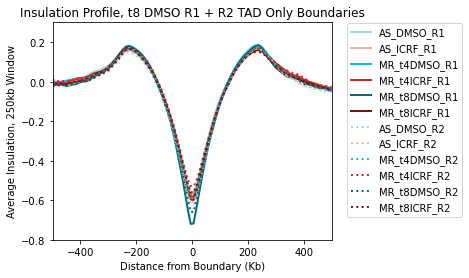

In [148]:
f, ax = plt.subplots(figsize=[5, 4])
flank = 500000
nbins = 100
x = np.linspace(-flank/1e3, flank/1e3, nbins)
for cond in SepConds:
    ax.plot(x, np.nanmean(ins_pileup_signal_TAD[cond], axis=0), color = sampleColors[cond], label = cond, 
            ls = sampleLineStyles[cond], lw = 2)
plt.xlim(-flank/1e3, flank/1e3)
plt.ylim(-.8, .3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.1)
plt.title('Insulation Profile, t8 DMSO R1 + R2 TAD Only Boundaries')
plt.ylabel('Average Insulation, 250kb Window')
plt.xlabel('Distance from Boundary (Kb)')
plt.savefig(f'{outDataDir}/figures/MRandASDMSOvsICRF_InsulationPileup_t8DMSOTADOnlyBoundaries.png', dpi = 300, 
            bbox_inches = 'tight')

In [149]:
#Loop pileups
binsize = 10000

In [150]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.core.construction.add_ucsc_name_column(bioframe.make_chromarms(hg38_chromsizes,  hg38_cens))


In [151]:
hg38_arms = hg38_arms[hg38_arms['chrom'].isin(good_chroms)]

In [152]:
#https://cooltools.readthedocs.io/en/latest/notebooks/pileup_CTCF.html
#Loop pileups - use loops that I called from deep 4DN data on this cell line

In [153]:
dot_file = f'{outDataDir}/data/4DN_HeLaS3_merged5and10kbbins_dots.txt.postproc.bedpe'

In [154]:
# Read dot data
dots = pd.read_table(dot_file)
dots['mid1'] = (dots['start1'] + dots['end1'])//2
dots['mid2'] = (dots['start2'] + dots['end2'])//2

In [155]:
dots

chrom1     start1       end1 chrom2     start2       end2       cstart1  \
0       chr1    1205000    1210000   chr1    1960000    1965000  1.205000e+06   
1       chr1    1920000    1930000   chr1    2040000    2050000  1.920000e+06   
2       chr1    1950000    1960000   chr1    2170000    2180000  1.947500e+06   
3       chr1    2190000    2200000   chr1    2390000    2400000  2.193000e+06   
4       chr1    2190000    2200000   chr1    2530000    2540000  2.190000e+06   
...      ...        ...        ...    ...        ...        ...           ...   
13380   chrX  153770000  153780000   chrX  153940000  153950000  1.537686e+08   
13381   chrX  154980000  154985000   chrX  155065000  155070000  1.549825e+08   
13382   chrX  155640000  155645000   chrX  155955000  155960000  1.556400e+08   
13383   chrY   10820000   10830000   chrY   11290000   11300000  1.082000e+07   
13384   chrY   10915000   10920000   chrY   11320000   11325000  1.091500e+07   

            cstart2  c_label  c_size  ...  la_exp.donut.value  \
0      1.960000e+06        1       1  ...            1.632441   
1      2.040000e+06        3       1  ...           51.249501   
2      2.162500e+06        4       4  ...           50.583795   
3      2.377000e+06        5      10  ...           81.044575   
4      2.530000e+06        6       1  ...           28.922743   
...             ...      ...     ...  ...                 ...   
13380  1.539429e+08      144       7  ...           43.867889   
13381  1.550650e+08       88       2  ...           27.334064   
13382  1.559550e+08       89       1  ...            1.979877   
13383  1.129000e+07        0       1  ...            0.031421   
13384  1.132000e+07        0       1  ...            0.872845   

       la_exp.vertical.value  la_exp.horizontal.value  la_exp.lowleft.value  \
0                   1.270888                 2.788023              1.459885   
1                  76.401514                55.615420             67.589923   
2                  60.451304                55.331996             56.289805   
3                 103.339125                99.121716             99.577322   
4                  34.956510                39.032832             27.680972   
...                      ...                      ...                   ...   
13380              54.689734                50.789632             48.962815   
13381              27.561402                39.065951             23.533584   
13382               1.854046                 2.655125              1.947406   
13383               0.210441                 0.002327              0.000000   
13384               0.067506                 0.095940              1.180125   

       la_exp.donut.qval  la_exp.vertical.qval  la_exp.horizontal.qval  \
0           1.378914e-05          5.248399e-07            3.534255e-03   
1           3.751650e-15          2.065853e-08            6.140863e-15   
2           1.697645e-08          2.570122e-04            2.524457e-04   
3           1.547166e-32          2.199940e-19            2.360430e-32   
4           1.786413e-05          7.074652e-03            6.931917e-03   
...                  ...                   ...                     ...   
13380       5.398886e-17          2.679343e-10            9.972159e-17   
13381       9.291680e-08          1.393731e-07            1.969409e-04   
13382       1.942851e-08          2.331567e-08            3.375523e-05   
13383       1.481264e-05          1.920837e-05            2.217708e-05   
13384       2.257185e-08          2.225094e-08            2.292319e-08   

       la_exp.lowleft.qval       mid1       mid2  
0             5.227220e-07    1207500    1962500  
1             1.743081e-08    1925000    2045000  
2             2.086008e-04    1955000    2175000  
3             2.195089e-32    2195000    2395000  
4             1.647271e-05    2195000    2535000  
...                    ...        ...        ...  
13380         6.674989e-17  153775000  153945000  
13381 

In [156]:
# Load colormap with large number of distinguishable intermediary tones,
# The "fall" colormap in cooltools is exactly for this purpose.
# After this step, you can use "fall" as cmap parameter in matplotlib:
import cooltools.lib.plotting

In [157]:
pd.DataFrame(hg38_arms).to_csv(f'{outDataDir}/data/hg38_goodchroms_arms.bed', sep = '\t', index = False, header = False)

In [158]:
for cond in conditions:
    in_fname = clr_paths_10kb[cond]
    region_fname = f'{outDataDir}/data/hg38_arms_filtered.bed'
    out_fname = f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.tsv'
    !bsub -q short -W 01:00 -e /lsf_jobs/LSB_%J.err -o /lsf_jobs/LSB_%J.log \
        -n 8 -R span[hosts=1] -R select[ib] -R rusage[mem=2000] -R select[rh=8] \
        "cooltools expected-cis -p 8 -o $out_fname --ignore-diags 2 --view $region_fname $in_fname"

Job <8237970> is submitted to queue <short>.
Job <8237971> is submitted to queue <short>.
Job <8237972> is submitted to queue <short>.
Job <8237973> is submitted to queue <short>.
Job <8237974> is submitted to queue <short>.
Job <8237975> is submitted to queue <short>.
Job <8237976> is submitted to queue <short>.
Job <8237977> is submitted to queue <short>.
Job <8237978> is submitted to queue <short>.
Job <8237979> is submitted to queue <short>.
Job <8237980> is submitted to queue <short>.
Job <8237981> is submitted to queue <short>.
Job <8237982> is submitted to queue <short>.
Job <8237983> is submitted to queue <short>.
Job <8237984> is submitted to queue <short>.
Job <8237985> is submitted to queue <short>.
Job <8237986> is submitted to queue <short>.
Job <8237987> is submitted to queue <short>.


In [159]:
flank = 200000

windows1 = cooltools.api.snipping.make_bin_aligned_windows(
    binsize,
    dots['chrom1'],
    dots['mid1'],
    flank_bp=flank)

windows2 = cooltools.api.snipping.make_bin_aligned_windows(
    binsize,
    dots['chrom2'],
    dots['mid2'],
    flank_bp=flank)

windows = pd.merge(windows1, windows2, left_index=True, right_index=True, suffixes=('1', '2'))
windows = cooltools.api.snipping.assign_regions(windows, hg38_arms)

In [160]:
windows = windows.dropna()

In [161]:
# use this if expected already run, will be much faster
cis_exp_cli = {}

for cond in conditions:
    cis_exp_cli[cond] = pd.read_csv(f'{outDataDir}/data/{long_names[cond]}.{binsize//1000}kb.mapq30.expected.cis.cli.tsv', sep = '\t')

In [162]:
# create the stack of snips:
stacks = {}
for cond in ComboConds:
    stacks[cond] = np.nanmean(cooltools.pileup(
        clrs10kb[cond], dots, view_df=hg38_arms_filtered.reset_index(drop = True), 
        expected_df=cis_exp_cli[cond], flank=200_000), axis = 2)

/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/api/snipping.py:229: UserWarning: Some features do not have view regions assigned! Some snips will be empty.
  warnings.warn(
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/api/snipping.py:229: UserWarning: Some features do not have view regions assigned! Some snips will be empty.
  warnings.warn(
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/api/snipping.py:229: UserWarning: Some features do not have view regions assigned! Some snips will be empty.
  warnings.warn(
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/api/snipping.py:229: UserWarning: Some features do not have view regions assigned! Some snips will be empty.
  warnings.warn(
/home/eh37w/bin/miniconda3/envs/open2c_cooler0.5.1/lib/python3.9/site-packages/cooltools/api/snipping.py:229: UserWarning: Some features do 

In [163]:
ComboCtrlConds = ['AS_DMSO_R1R2', 'MR_t4DMSO_R1R2', 'MR_t8DMSO_R1R2']
ComboTreatConds = ['AS_ICRF_R1R2', 'MR_t4ICRF_R1R2', 'MR_t8ICRF_R1R2']

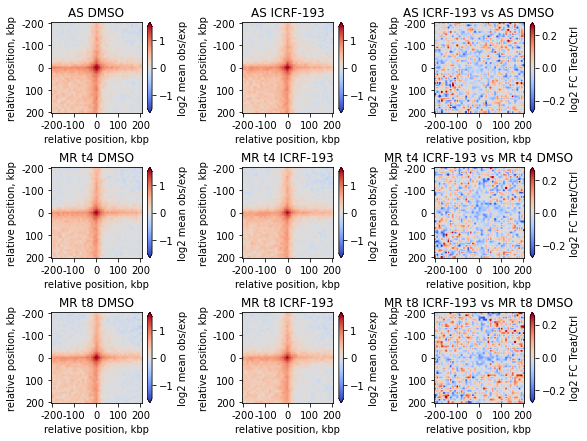

In [164]:
#Pileup Hi-C data at loops
binsize = 10000
gs = GridSpec(nrows= 3, ncols=3, wspace = .6, hspace = 0.6)
plt.figure(figsize=(9, 7))

for i, cond in enumerate(ComboCtrlConds):
    ax = plt.subplot(gs[i, 0])
    img = ax.imshow(
        np.log2(stacks[cond]),
        vmax = 1.5,
        vmin = -1.5,
        cmap='coolwarm')

    plt.colorbar(img, label = 'log2 mean obs/exp', extend = 'both')
    ticks_pixels = np.linspace(0, flank*2//binsize,5)
    ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*binsize//1000).astype(int)
    plt.xticks(ticks_pixels, ticks_kbp)
    plt.yticks(ticks_pixels, ticks_kbp)
    plt.xlabel('relative position, kbp')
    plt.ylabel('relative position, kbp')
    plt.title(samplePlotNames[cond])
    
for i, cond in enumerate(ComboTreatConds):
    ax = plt.subplot(gs[i, 1])
    img = ax.imshow(
        np.log2(stacks[cond]),
        vmax = 1.5,
        vmin = -1.5,
        cmap='coolwarm')

    plt.colorbar(img, label = 'log2 mean obs/exp', extend = 'both')
    ticks_pixels = np.linspace(0, flank*2//binsize,5)
    ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*binsize//1000).astype(int)
    plt.xticks(ticks_pixels, ticks_kbp)
    plt.yticks(ticks_pixels, ticks_kbp)
    plt.xlabel('relative position, kbp')
    plt.ylabel('relative position, kbp')
    plt.title(samplePlotNames[cond])

for i, (treatcond, ctrlcond) in enumerate(zip(ComboTreatConds, ComboCtrlConds)):
    ax = plt.subplot(gs[i, 2])
    img = ax.imshow(
        (np.log2(stacks[treatcond]) - np.log2(stacks[ctrlcond])),
        vmax = .25,
        vmin = -.25,
        cmap='coolwarm')

    plt.colorbar(img, label = 'log2 FC Treat/Ctrl', extend = 'both')
    ticks_pixels = np.linspace(0, flank*2//binsize,5)
    ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*binsize//1000).astype(int)
    plt.xticks(ticks_pixels, ticks_kbp)
    plt.yticks(ticks_pixels, ticks_kbp)
    plt.xlabel('relative position, kbp')
    plt.ylabel('relative position, kbp')
    plt.title(f'{samplePlotNames[treatcond]} vs {samplePlotNames[ctrlcond]}')
    
plt.savefig("{}/figures/220515_MRandASICRFHeLa_R1R2Combined_LoopPileup_4DNDeepHeLaloops.png".format(outDataDir), dpi = 300, bbox_inches = 'tight')